# Combined GPT FlashAttention Benchmark Suite

This notebook combines all benchmark functionality:
- Basic FlashAttention vs Math backend comparison
- Optimized benchmarks for longer sequences
- Results analysis and visualization

**Target hardware:** NVIDIA A100 with bfloat16 support

## Setup and Configuration

In [1]:
import os, time, torch
import json
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.backends.cuda import sdp_kernel
from typing import Dict, Any, List
import shutil
import subprocess
import gc

# ===== CUDA CLEANUP AND DEBUGGING =====
print("="*60)
print("CUDA CLEANUP AND INITIALIZATION")
print("="*60)

# Force cleanup of any existing CUDA contexts
if torch.cuda.is_available():
    try:
        print("🧹 Cleaning up CUDA contexts...")
        torch.cuda.empty_cache()
        gc.collect()
        
        # Force synchronize all devices
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
        
        print("✅ CUDA cleanup completed")
        
        # Test CUDA availability
        test_tensor = torch.randn(10, 10).cuda()
        _ = test_tensor @ test_tensor.T
        torch.cuda.synchronize()
        print("✅ CUDA test passed")
        del test_tensor
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"⚠️ CUDA cleanup warning: {e}")
        print("💡 This may indicate GPU processes are still running")

# Enable CUDA debugging if errors occur
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # Synchronous CUDA for better error reporting
print("🔧 Enabled CUDA_LAUNCH_BLOCKING for debugging")

# ===== RUNPOD STORAGE CONFIGURATION =====
# Ensure models download to the 100GB volume, not 20GB container disk
os.environ["HF_HOME"] = "/data/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/data/huggingface/transformers"  
os.environ["HF_DATASETS_CACHE"] = "/data/huggingface/datasets"
os.environ["TORCH_HOME"] = "/data/torch"

# Enable memory fragmentation fix
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Performance optimizations (A100)
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")
os.environ.setdefault("TORCH_LOGS", "inductor")

# ===== STORAGE VERIFICATION =====
print("\n" + "="*60)
print("RUNPOD STORAGE VERIFICATION")
print("="*60)

def check_storage():
    """Verify storage paths and available space"""
    try:
        # Check if /data volume is mounted
        if os.path.exists("/data"):
            print("✅ /data volume found")
            
            # Get disk space for /data volume (100GB)
            statvfs = os.statvfs("/data")
            data_total = statvfs.f_frsize * statvfs.f_blocks / (1024**3)  # GB
            data_free = statvfs.f_frsize * statvfs.f_bavail / (1024**3)   # GB
            data_used = data_total - data_free
            
            print(f"📊 /data volume: {data_used:.1f}GB used / {data_total:.1f}GB total ({data_free:.1f}GB free)")
            
            if data_free < 15:
                print("⚠️  Warning: Less than 15GB free on /data volume")
            else:
                print("✅ Sufficient space for models")
                
        else:
            print("❌ /data volume not found - models will download to container disk!")
            return False
            
        # Check container disk space (20GB)
        statvfs_root = os.statvfs("/")
        root_total = statvfs_root.f_frsize * statvfs_root.f_blocks / (1024**3)
        root_free = statvfs_root.f_frsize * statvfs_root.f_bavail / (1024**3)
        root_used = root_total - root_free
        
        print(f"📊 Container disk: {root_used:.1f}GB used / {root_total:.1f}GB total ({root_free:.1f}GB free)")
        
        # Create cache directories
        os.makedirs("/data/huggingface/transformers", exist_ok=True)
        os.makedirs("/data/huggingface/datasets", exist_ok=True) 
        os.makedirs("/data/torch", exist_ok=True)
        print("✅ Cache directories created on /data volume")
        
        return True
        
    except Exception as e:
        print(f"❌ Storage check failed: {e}")
        return False

storage_ok = check_storage()

print(f"\n🗂️  HuggingFace cache: {os.environ.get('HF_HOME', 'default')}")
print(f"🗂️  Transformers cache: {os.environ.get('TRANSFORMERS_CACHE', 'default')}")
print(f"🗂️  PyTorch cache: {os.environ.get('TORCH_HOME', 'default')}")

if not storage_ok:
    print("\n❌ STORAGE CONFIGURATION ISSUE")
    print("💡 Models may download to limited container disk instead of 100GB volume")

# ===== GPU STATUS =====
print(f"\n🔧 PyTorch: {torch.__version__}")
print(f"🔧 CUDA: {torch.version.cuda}")
print(f"🔧 BF16 supported: {torch.cuda.is_bf16_supported()}")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")
print(f"🔧 GPU count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        memory_gb = props.total_memory // (1024**3)
        print(f"🔧 GPU {i}: {props.name} ({memory_gb}GB)")

print("="*60)

I0829 00:34:01.098000 293 torch/_inductor/config.py:799] compile_threads set to 32


CUDA CLEANUP AND INITIALIZATION
🧹 Cleaning up CUDA contexts...
✅ CUDA cleanup completed
✅ CUDA test passed
🔧 Enabled CUDA_LAUNCH_BLOCKING for debugging

RUNPOD STORAGE VERIFICATION
✅ /data volume found
📊 /data volume: 294140.1GB used / 429177.3GB total (135037.2GB free)
✅ Sufficient space for models
📊 Container disk: 0.0GB used / 50.0GB total (50.0GB free)
✅ Cache directories created on /data volume

🗂️  HuggingFace cache: /data/huggingface
🗂️  Transformers cache: /data/huggingface/transformers
🗂️  PyTorch cache: /data/torch

🔧 PyTorch: 2.8.0+cu128
🔧 CUDA: 12.8
🔧 BF16 supported: True
🔧 CUDA available: True
🔧 GPU count: 8
🔧 GPU 0: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 1: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 2: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 3: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 4: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 5: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 6: NVIDIA A100 80GB PCIe (79GB)
🔧 GPU 7: NVIDIA A100 80GB PCIe (79GB)


In [2]:
# GPT-NeoX-20B FRESH LOAD - No references to previous models
MODEL_ID = "EleutherAI/gpt-neox-20b"  # 🚀 20B parameters ONLY
DTYPE = torch.bfloat16
DEVICE_MAP = "auto"  

print("🔥🔥🔥 LOADING GPT-NeoX-20B FRESH 🔥🔥🔥")
print("💪 20 BILLION parameters for REVOLUTIONARY FlashAttention speedups!")

def check_storage():
    """Check storage space"""
    try:
        statvfs = os.statvfs("/data")
        free_gb = statvfs.f_frsize * statvfs.f_bavail / (1024**3)
        print(f"💾 Available space: {free_gb:.1f}GB")
        return free_gb > 50
    except:
        return True

# Skip CUDA tests - go straight to loading
if not check_storage():
    print("❌ Need at least 50GB free space")
    raise RuntimeError("Insufficient storage")

print("📥 Loading GPT-NeoX-20B tokenizer...")
try:
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_ID,
        use_fast=True,
        cache_dir="/data/huggingface/transformers"
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("✅ Tokenizer loaded")
except Exception as e:
    print(f"❌ Tokenizer failed: {e}")
    raise

print("📥 Loading GPT-NeoX-20B model...")
print("⏳ This takes 10-15 minutes (40GB download + GPU distribution)")

try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=DTYPE,
        attn_implementation="sdpa",
        device_map=DEVICE_MAP,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        cache_dir="/data/huggingface/transformers",
        offload_folder="/data/offload"
    ).eval()
    
    print("✅ GPT-NeoX-20B loaded successfully!")
    
except Exception as e:
    print(f"❌ Model loading failed: {e}")
    if "CUDA" in str(e):
        print("💡 GPU issue - try restarting RunPod instance completely")
    elif "memory" in str(e):
        print("💡 Memory issue - check available RAM/storage")
    raise

# Show GPU distribution
print(f"✅ Attention: {getattr(model.config, '_attn_implementation', 'unknown')}")
if hasattr(model, 'hf_device_map'):
    used_gpus = set()
    for layer, device in model.hf_device_map.items():
        if isinstance(device, int):
            used_gpus.add(device)
        elif 'cuda' in str(device):
            gpu_num = int(str(device).split(':')[-1]) if ':' in str(device) else 0
            used_gpus.add(gpu_num)
    
    print(f"✅ Using GPUs: {sorted(used_gpus)}")
    total_mem = 0
    for gpu_id in sorted(used_gpus):
        if gpu_id < torch.cuda.device_count():
            mem_gb = torch.cuda.memory_allocated(gpu_id) / (1024**3)
            total_mem += mem_gb
            print(f"  GPU {gpu_id}: {mem_gb:.1f}GB")
    
    print(f"🔥 Total: {total_mem:.1f}GB across {len(used_gpus)} GPUs")

print("\n🎉 GPT-NeoX-20B READY FOR REVOLUTIONARY BENCHMARKING! 🎉")

🔥🔥🔥 LOADING GPT-NeoX-20B FRESH 🔥🔥🔥
💪 20 BILLION parameters for REVOLUTIONARY FlashAttention speedups!
💾 Available space: 135037.2GB
📥 Loading GPT-NeoX-20B tokenizer...


tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

✅ Tokenizer loaded
📥 Loading GPT-NeoX-20B model...
⏳ This takes 10-15 minutes (40GB download + GPU distribution)


config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 46 files:   0%|          | 0/46 [00:00<?, ?it/s]

model-00001-of-00046.safetensors:   0%|          | 0.00/926M [00:00<?, ?B/s]

model-00002-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00008-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00005-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00004-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00003-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00007-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00006-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00009-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00010-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00012-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00014-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00013-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00015-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00011-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00016-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00017-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00020-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00018-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00019-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00021-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00022-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00023-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00024-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00025-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00026-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00027-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00029-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00028-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00030-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00031-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00032-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00033-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00034-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00035-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00036-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00037-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00038-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00039-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00040-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00041-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00042-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00043-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00044-of-00046.safetensors:   0%|          | 0.00/910M [00:00<?, ?B/s]

model-00045-of-00046.safetensors:   0%|          | 0.00/604M [00:00<?, ?B/s]

model-00046-of-00046.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/46 [00:00<?, ?it/s]

✅ GPT-NeoX-20B loaded successfully!
✅ Attention: sdpa
✅ Using GPUs: [0, 1, 2, 3, 4, 5, 6, 7]
  GPU 0: 4.8GB
  GPU 1: 5.1GB
  GPU 2: 5.1GB
  GPU 3: 5.1GB
  GPU 4: 5.1GB
  GPU 5: 5.1GB
  GPU 6: 5.1GB
  GPU 7: 3.1GB
🔥 Total: 38.3GB across 8 GPUs

🎉 GPT-NeoX-20B READY FOR REVOLUTIONARY BENCHMARKING! 🎉


In [3]:
# Check FlashAttention support and availability
print("="*60)
print("FLASHATTENTION DIAGNOSTIC CHECK")
print("="*60)

from torch.backends.cuda import flash_sdp_enabled, math_sdp_enabled, mem_efficient_sdp_enabled

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1e9:.1f}GB")

print(f"\nSDPA Backend Support:")
print(f"  Flash SDP enabled: {flash_sdp_enabled()}")
print(f"  Math SDP enabled: {math_sdp_enabled()}")
print(f"  Mem efficient SDP enabled: {mem_efficient_sdp_enabled()}")

# Test kernel selection with a small example
print(f"\nKernel Selection Test:")
test_tensor = torch.randn(1, 8, 512, 64, device='cuda', dtype=torch.bfloat16)
query = key = value = test_tensor

# Test Flash kernel
try:
    with torch.backends.cuda.sdp_kernel(enable_flash=True, enable_math=False, enable_mem_efficient=False):
        torch.cuda.synchronize()
        t0 = time.time()
        _ = torch.nn.functional.scaled_dot_product_attention(query, key, value)
        torch.cuda.synchronize()
        flash_time = (time.time() - t0) * 1000
        print(f"  Flash kernel test: {flash_time:.2f}ms ✅")
except Exception as e:
    print(f"  Flash kernel test: FAILED - {e}")
    flash_time = float('inf')

# Test Math kernel  
try:
    with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False):
        torch.cuda.synchronize()
        t0 = time.time()
        _ = torch.nn.functional.scaled_dot_product_attention(query, key, value)
        torch.cuda.synchronize() 
        math_time = (time.time() - t0) * 1000
        print(f"  Math kernel test: {math_time:.2f}ms ✅")
except Exception as e:
    print(f"  Math kernel test: FAILED - {e}")
    math_time = float('inf')

# Quick performance comparison
if flash_time != float('inf') and math_time != float('inf'):
    speedup = math_time / flash_time
    print(f"  Kernel speedup (Flash vs Math): {speedup:.2f}x")
    if speedup > 1.2:
        print(f"  ✅ Flash kernel shows benefit on test sequence")
    elif speedup > 0.8:
        print(f"  ⚠️  Flash and Math kernels perform similarly") 
    else:
        print(f"  ❌ Math kernel faster than Flash on test sequence")
else:
    print(f"  ❌ Could not compare kernel performance")

print("="*60)

FLASHATTENTION DIAGNOSTIC CHECK
PyTorch version: 2.8.0+cu128
CUDA version: 12.8
GPU: NVIDIA A100 80GB PCIe
GPU Memory: 84.0GB

SDPA Backend Support:
  Flash SDP enabled: True
  Math SDP enabled: True
  Mem efficient SDP enabled: True

Kernel Selection Test:
  Flash kernel test: 9.84ms ✅
  Math kernel test: 71.38ms ✅
  Kernel speedup (Flash vs Math): 7.26x
  ✅ Flash kernel shows benefit on test sequence


/usr/lib/python3.10/contextlib.py:103: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


## FlashAttention Diagnostics

## Utility Functions

In [4]:
def generate_diverse_prompts(target_tokens: int, prompt_type: str = "generic") -> str:
    """Generate diverse prompts for different use cases - UPGRADED for GPT-NeoX-20B"""
    
    prompt_templates = {
        "generic": "The quick brown fox jumps over the lazy dog. This is a sample text for benchmarking purposes with various interesting content. ",
        
        "math": """Solve this step by step: Given the quadratic equation ax² + bx + c = 0, where a = 2, b = -7, c = 3.
Step 1: Identify coefficients and apply the quadratic formula.
Step 2: Calculate the discriminant Δ = b² - 4ac.
Step 3: Find the roots using x = (-b ± √Δ) / 2a.
This mathematical analysis requires careful attention to algebraic manipulation. """,
        
        "coding": """Write a Python function to implement a binary search tree with the following requirements:
1. Insert nodes maintaining BST property
2. Search for values efficiently  
3. Delete nodes while preserving structure
4. Include comprehensive error handling
5. Add docstrings and type hints
6. Write unit tests covering edge cases
Here's a detailed implementation with explanations and optimizations: """,
        
        "reasoning": """Analyze this logical puzzle step by step:
There are 5 houses in a row, each painted a different color.
- The red house is immediately to the left of the blue house
- The green house is somewhere to the left of the white house  
- The yellow house is not at either end
- The blue house is in the middle position
Given these constraints, let's work through the solution systematically: """,
        
        "creative": """Write a compelling short story with the following elements:
Setting: A futuristic city where memories can be traded like currency
Character: A memory merchant who discovers they've been selling fake memories
Conflict: The merchant must choose between exposing the truth or protecting their livelihood
Theme: The value of authentic experiences vs comfortable illusions
Style: Blend cyberpunk aesthetics with philosophical depth and emotional resonance
Here's the story that explores these complex themes: """,
        
        "analysis": """Provide a comprehensive analysis of the economic implications of artificial intelligence:
1. Labor market disruption across different sectors and skill levels
2. Productivity gains and GDP growth potential in various industries
3. Income inequality and wealth distribution effects on society
4. Policy recommendations for managing the transition effectively
5. International competitiveness considerations and trade implications
6. Timeline for various impacts to materialize across different regions
This detailed analysis examines both opportunities and challenges: """
    }
    
    base_text = prompt_templates.get(prompt_type, prompt_templates["generic"])
    
    # Use character-based estimation (more generous for longer sequences)
    target_chars = target_tokens * 4  # Standard estimation
    
    # For very long sequences, add more sophisticated variation
    if target_tokens > 5000:
        # Add chapter-like structure for ultra-long sequences
        variations = [
            f"\n\nChapter 1: Introduction\n{base_text}",
            f"\n\nChapter 2: Detailed Analysis\n{base_text}",
            f"\n\nChapter 3: Advanced Concepts\n{base_text}",
            f"\n\nChapter 4: Implementation Details\n{base_text}",
            f"\n\nChapter 5: Case Studies\n{base_text}",
            f"\n\nChapter 6: Future Implications\n{base_text}",
        ]
        
        result = base_text
        chapter = 0
        while len(result) < target_chars and chapter < len(variations):
            result += variations[chapter]
            chapter += 1
            
        # Fill remaining space with base content if needed
        while len(result) < target_chars:
            result += f" {base_text}"
            if len(result) >= target_chars:
                break
                
        return result[:target_chars]
    
    else:
        # Standard repetition for shorter sequences
        repetitions = (target_chars // len(base_text)) + 1
        result = (base_text * repetitions)[:target_chars]
        return result

@torch.inference_mode()
def bench_with_backend(prompt_len: int, gen_tokens: int = 128, backend_name: str = "auto", 
                      force_flash=None, force_math=None, batch_size=1, prompt_type="generic") -> Dict[str, Any]:
    """
    Benchmark with specific attention backend - UPGRADED for GPT-NeoX-20B long sequences
    """
    print(f"  🎯 Testing {prompt_len} token sequence with {backend_name} backend...")
    
    # Generate prompts
    if batch_size == 1:
        prompt = generate_diverse_prompts(prompt_len, prompt_type)
        inputs = tokenizer(prompt, return_tensors="pt", max_length=prompt_len, truncation=True).to(model.device)
        
        actual_len = inputs.input_ids.shape[1]
        print(f"  📝 Generated prompt: {actual_len} tokens")
    else:
        prompts = [generate_diverse_prompts(prompt_len, prompt_type) + f" Batch context variant {i}." for i in range(batch_size)]
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=prompt_len)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        actual_len = inputs["input_ids"].shape[1]
        print(f"  📝 Generated batch: {batch_size}x{actual_len} tokens")
    
    # Setup backend context
    if force_flash is not None or force_math is not None:
        enable_flash = force_flash if force_flash is not None else False
        enable_math = force_math if force_math is not None else False
        enable_mem_efficient = not (enable_flash or enable_math)
        
        ctx = sdp_kernel(
            enable_flash=enable_flash,
            enable_math=enable_math, 
            enable_mem_efficient=enable_mem_efficient
        )
        print(f"  ⚙️  Backend: flash={enable_flash}, math={enable_math}, mem_eff={enable_mem_efficient}")
    else:
        from contextlib import nullcontext
        ctx = nullcontext()
        print(f"  ⚙️  Using automatic backend selection")
    
    # Clear cache and monitor memory
    torch.cuda.empty_cache()
    
    # Show memory usage across all GPUs before test
    total_mem_before = 0
    for i in range(torch.cuda.device_count()):
        mem_before = torch.cuda.memory_allocated(i) / 1e9
        total_mem_before += mem_before
    
    try:
        with ctx:
            # Prefill benchmark (this is where FlashAttention shines!)
            print(f"  ⏱️  Starting prefill benchmark...")
            torch.cuda.synchronize()
            t0 = time.time()
            _ = model(**inputs)
            torch.cuda.synchronize()
            prefill_ms = (time.time() - t0) * 1000
            
            # Check peak memory across all GPUs
            total_mem_peak = 0
            for i in range(torch.cuda.device_count()):
                total_mem_peak += torch.cuda.max_memory_allocated(i) / 1e9
            
            # Generation benchmark  
            print(f"  ⏱️  Starting decode benchmark...")
            torch.cuda.synchronize()
            t1 = time.time()
            out = model.generate(
                **inputs, 
                max_new_tokens=gen_tokens, 
                do_sample=False, 
                use_cache=True,
                pad_token_id=tokenizer.eos_token_id
            )
            torch.cuda.synchronize()
            decode_s = time.time() - t1

    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            raise RuntimeError(f"OOM error - try reducing batch size or sequence length")
        else:
            raise RuntimeError(f"Runtime error: {str(e)[:200]}...")

    # Calculate metrics
    if batch_size > 1:
        actual_input_len = inputs["input_ids"].shape[1]
        new_tok_total = (out.shape[1] - actual_input_len) * batch_size
        tok_per_s = new_tok_total / max(decode_s, 1e-9)
    else:
        new_tok = out.shape[1] - inputs["input_ids"].shape[1]
        tok_per_s = new_tok / max(decode_s, 1e-9)
    
    print(f"  📊 Results: Prefill: {prefill_ms:>8.1f}ms | Decode: {decode_s:>6.2f}s | {tok_per_s:>7.1f} tok/s | Mem: {total_mem_peak:.1f}GB")
    
    return {
        "prefill_ms": prefill_ms, 
        "decode_s": decode_s, 
        "tok_per_s": tok_per_s,
        "batch_size": batch_size,
        "prompt_len": actual_len,
        "backend": backend_name,
        "gen_tokens": gen_tokens,
        "memory_peak_gb": total_mem_peak,
        "prompt_type": prompt_type
    }

## Basic Benchmark: Short to Medium Sequences

In [5]:
# Enhanced benchmark - Complete capability boundary analysis
basic_results = []
failure_mapping = {"math_backend": {}, "flashattention": {}}

print("="*60)
print("CAPABILITY BOUNDARY ANALYSIS")
print("Testing sequence lengths to map complete failure boundaries")
print("="*60)

# Extended sequence lengths including extreme tests to find FlashAttention limits
test_lengths = [2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288]

for L in test_lengths:
    print(f"\nTesting sequence length: {L:,} tokens")
    
    # Track memory before testing
    torch.cuda.empty_cache()
    total_available = sum((torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i)) 
                         for i in range(torch.cuda.device_count()))
    available_gb = total_available / (1024**3)
    print(f"Available memory: {available_gb:.1f}GB")
    
    # Test FlashAttention first (more likely to succeed)
    flash_success = False
    math_success = False
    
    # FlashAttention test
    try:
        print("Testing FlashAttention backend...")
        flash_result = bench_with_backend(
            prompt_len=L, 
            gen_tokens=max(4, 64 - L//2000),  # Reduce generation for extreme lengths
            backend_name="FLASH",
            force_flash=True,
            force_math=False
        )
        basic_results.append(flash_result)
        flash_success = True
        
        failure_mapping["flashattention"][L] = {
            "status": "SUCCESS",
            "prefill_ms": flash_result["prefill_ms"],
            "memory_gb": flash_result.get("memory_peak_gb", 0),
            "tok_per_s": flash_result.get("tok_per_s", 0),
            "details": f"Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB"
        }
        
        print(f"FlashAttention SUCCESS - Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB")
        torch.cuda.empty_cache()
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"FlashAttention OOM at {L:,} tokens")
            failure_mapping["flashattention"][L] = {
                "status": "OOM", 
                "error": str(e)[:100],
                "available_gb": available_gb,
                "details": f"OOM - {available_gb:.1f}GB available insufficient"
            }
        else:
            print(f"FlashAttention error: {str(e)[:100]}")
            failure_mapping["flashattention"][L] = {
                "status": "ERROR",
                "error": str(e)[:100],
                "details": "Runtime error"
            }
        torch.cuda.empty_cache()
    
    # Math backend test (expect early failures)
    try:
        print("Testing Math backend...")
        math_result = bench_with_backend(
            prompt_len=L,
            gen_tokens=max(4, 64 - L//2000),
            backend_name="MATH", 
            force_flash=False,
            force_math=True
        )
        basic_results.append(math_result)
        math_success = True
        
        failure_mapping["math_backend"][L] = {
            "status": "SUCCESS",
            "prefill_ms": math_result["prefill_ms"], 
            "memory_gb": math_result.get("memory_peak_gb", 0),
            "tok_per_s": math_result.get("tok_per_s", 0),
            "details": f"Prefill: {math_result['prefill_ms']:.1f}ms, Memory: {math_result.get('memory_peak_gb', 0):.1f}GB"
        }
        
        print(f"Math Backend SUCCESS - Prefill: {math_result['prefill_ms']:.1f}ms, Memory: {math_result.get('memory_peak_gb', 0):.1f}GB")
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"Math Backend OOM at {L:,} tokens (expected)")
            
            # Calculate estimated memory usage
            estimated_attention_memory = (L * L * 2) / (1024**3)  # bfloat16 attention matrix
            failure_mapping["math_backend"][L] = {
                "status": "OOM",
                "estimated_memory_gb": estimated_attention_memory,
                "available_gb": available_gb,
                "error": str(e)[:100],
                "details": f"OOM - Estimated {estimated_attention_memory:.1f}GB needed for attention matrix"
            }
            print(f"Estimated attention matrix memory: {estimated_attention_memory:.1f}GB")
        else:
            print(f"Math Backend error: {str(e)[:100]}")
            failure_mapping["math_backend"][L] = {
                "status": "ERROR",
                "error": str(e)[:100], 
                "details": "Runtime error"
            }
        torch.cuda.empty_cache()
    
    # Analysis
    if flash_success and math_success:
        prefill_speedup = math_result["prefill_ms"] / flash_result["prefill_ms"]
        print(f"Both operational - FlashAttention {prefill_speedup:.2f}x speedup")
    elif flash_success and not math_success:
        print(f"Capability boundary: FlashAttention enables {L:,} tokens, Math backend fails")
    elif not flash_success and not math_success:
        print(f"Hardware limit reached at {L:,} tokens")
        break
    
    torch.cuda.empty_cache()

# Summary
print(f"\n" + "="*60)
print("CAPABILITY BOUNDARY SUMMARY")
print("="*60)

print("\nMath Backend Results:")
for length, result in sorted(failure_mapping["math_backend"].items()):
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    print(f"  {length:>7,} tokens: {status} - {result['details']}")

print("\nFlashAttention Results:")  
for length, result in sorted(failure_mapping["flashattention"].items()):
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    print(f"  {length:>7,} tokens: {status} - {result['details']}")

# Find boundaries
math_max = max([k for k, v in failure_mapping["math_backend"].items() if v["status"] == "SUCCESS"], default=0)
flash_max = max([k for k, v in failure_mapping["flashattention"].items() if v["status"] == "SUCCESS"], default=0)

if flash_max > math_max:
    improvement_ratio = flash_max / math_max if math_max > 0 else float('inf')
    print(f"\nCapability Improvement Summary:")
    print(f"  Math Backend Maximum: {math_max:,} tokens")
    print(f"  FlashAttention Maximum: {flash_max:,} tokens")
    print(f"  Sequence Length Improvement: {improvement_ratio:.1f}x")
    
    if improvement_ratio >= 8:
        print(f"  Result: Revolutionary capability improvement (8x+ longer sequences)")
    elif improvement_ratio >= 4:
        print(f"  Result: Major capability improvement (4-8x longer sequences)")
    else:
        print(f"  Result: Significant capability improvement")
else:
    print(f"\nNo clear capability advantage detected")

print(f"\nBasic benchmark complete. Collected {len(basic_results)} performance measurements.")

CAPABILITY BOUNDARY ANALYSIS
Testing sequence lengths to map complete failure boundaries

Testing sequence length: 2,048 tokens
Available memory: 594.8GB
Testing FlashAttention backend...
  🎯 Testing 2048 token sequence with FLASH backend...
  📝 Generated prompt: 1551 tokens
  ⚙️  Backend: flash=True, math=False, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    762.2ms | Decode:   3.17s |    19.9 tok/s | Mem: 48.1GB
FlashAttention SUCCESS - Prefill: 762.2ms, Memory: 48.1GB
Testing Math backend...
  🎯 Testing 2048 token sequence with MATH backend...
  📝 Generated prompt: 1551 tokens
  ⚙️  Backend: flash=False, math=True, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    713.3ms | Decode:   4.05s |    15.5 tok/s | Mem: 57.6GB
Math Backend SUCCESS - Prefill: 713.3ms, Memory: 57.6GB
Both operational - FlashAttention 0.94x speedup

Testing sequence length: 4,096 tokens
Av

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    736.5ms | Decode:   3.73s |    16.6 tok/s | Mem: 61.1GB
FlashAttention SUCCESS - Prefill: 736.5ms, Memory: 61.1GB
Testing Math backend...
  🎯 Testing 4096 token sequence with MATH backend...
  📝 Generated prompt: 3097 tokens
  ⚙️  Backend: flash=False, math=True, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:   1989.6ms | Decode:   6.08s |    10.2 tok/s | Mem: 96.1GB
Math Backend SUCCESS - Prefill: 1989.6ms, Memory: 96.1GB
Both operational - FlashAttention 2.70x speedup

Testing sequence length: 8,192 tokens
Available memory: 594.8GB
Testing FlashAttention backend...
  🎯 Testing 8192 token sequence with FLASH backend...
  📝 Generated prompt: 6411 tokens
  ⚙️  Backend: flash=True, math=False, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:   1596.9ms | Decode:   5.19s |    11.6 tok/s | Mem: 103.1GB
FlashAttenti

## Optimized Benchmark: Longer Sequences & Batches

In [6]:
# Optimized benchmark - Complete failure mapping for various configurations
optimized_results = []
optimized_failure_mapping = {"math_backend": {}, "flashattention": {}}

print("\n" + "="*80)
print("OPTIMIZED BENCHMARK - CONFIGURATION TESTING")
print("GPT-NeoX-20B: Testing various sequence lengths and batch sizes")
print("="*80)

# Test configurations including extreme lengths for FlashAttention boundary detection
test_configs = [
    # Progressive sequence lengths
    {"prompt_len": 4096, "batch_size": 1, "gen_tokens": 32, "note": "4K baseline"},
    {"prompt_len": 8192, "batch_size": 1, "gen_tokens": 16, "note": "8K moderate"},
    {"prompt_len": 16384, "batch_size": 1, "gen_tokens": 8, "note": "16K high"},
    {"prompt_len": 32768, "batch_size": 1, "gen_tokens": 4, "note": "32K extreme"},
    {"prompt_len": 65536, "batch_size": 1, "gen_tokens": 4, "note": "65K ultra"},
    {"prompt_len": 131072, "batch_size": 1, "gen_tokens": 4, "note": "128K maximum"},
    
    # Batch processing tests
    {"prompt_len": 4096, "batch_size": 2, "gen_tokens": 16, "note": "4K batch=2"},
    {"prompt_len": 8192, "batch_size": 2, "gen_tokens": 8, "note": "8K batch=2"},
    {"prompt_len": 16384, "batch_size": 2, "gen_tokens": 4, "note": "16K batch=2"},
]

for config in test_configs:
    try:
        note = config.pop("note")
        config_id = f"{config['prompt_len']}_{config['batch_size']}"
        
        print(f"\n{note.upper()}: {config}")
        
        # Check available memory
        torch.cuda.empty_cache()
        total_available_memory = 0
        for i in range(torch.cuda.device_count()):
            available = torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i)
            total_available_memory += available
        
        available_gb = total_available_memory / (1024**3)
        print(f"Available memory: {available_gb:.1f}GB across {torch.cuda.device_count()} GPUs")
        
        flash_success = False
        math_success = False
        
        # FlashAttention test
        try:
            print("Testing FlashAttention...")
            flash_result = bench_with_backend(
                **config,
                backend_name="FLASH",
                force_flash=True,
                force_math=False,
                prompt_type="analysis"
            )
            optimized_results.append(flash_result)
            flash_success = True
            
            optimized_failure_mapping["flashattention"][config_id] = {
                "status": "SUCCESS",
                "config": config.copy(),
                "prefill_ms": flash_result["prefill_ms"],
                "memory_gb": flash_result.get("memory_peak_gb", 0),
                "tok_per_s": flash_result.get("tok_per_s", 0),
                "details": f"Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB, Throughput: {flash_result.get('tok_per_s', 0):.1f}tok/s"
            }
            
            print(f"FlashAttention SUCCESS - Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB")
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"FlashAttention OOM")
                optimized_failure_mapping["flashattention"][config_id] = {
                    "status": "OOM",
                    "config": config.copy(),
                    "error": str(e)[:100],
                    "available_gb": available_gb,
                    "details": f"OOM - {available_gb:.1f}GB insufficient"
                }
            else:
                print(f"FlashAttention error: {str(e)[:100]}")
                optimized_failure_mapping["flashattention"][config_id] = {
                    "status": "ERROR",
                    "config": config.copy(),
                    "error": str(e)[:100],
                    "details": "Runtime error"
                }
        
        # Memory cleanup
        torch.cuda.empty_cache()
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.empty_cache()
        time.sleep(1)
        
        # Math backend test
        try:
            print("Testing Math backend...")
            math_result = bench_with_backend(
                **config,
                backend_name="MATH", 
                force_flash=False,
                force_math=True,
                prompt_type="analysis"
            )
            optimized_results.append(math_result)
            math_success = True
            
            optimized_failure_mapping["math_backend"][config_id] = {
                "status": "SUCCESS",
                "config": config.copy(),
                "prefill_ms": math_result["prefill_ms"],
                "memory_gb": math_result.get("memory_peak_gb", 0),
                "tok_per_s": math_result.get("tok_per_s", 0),
                "details": f"Prefill: {math_result['prefill_ms']:.1f}ms, Memory: {math_result.get('memory_peak_gb', 0):.1f}GB, Throughput: {math_result.get('tok_per_s', 0):.1f}tok/s"
            }
            
            print(f"Math Backend SUCCESS - Prefill: {math_result['prefill_ms']:.1f}ms, Memory: {math_result.get('memory_peak_gb', 0):.1f}GB")
            
        except torch.cuda.OutOfMemoryError as e:
            print(f"Math Backend OOM (expected for longer sequences)")
            
            L = config["prompt_len"]
            B = config["batch_size"] 
            estimated_attention_memory = (B * L * L * 2) / (1024**3)
            
            optimized_failure_mapping["math_backend"][config_id] = {
                "status": "OOM",
                "config": config.copy(),
                "estimated_memory_gb": estimated_attention_memory,
                "available_gb": available_gb,
                "error": str(e)[:100],
                "details": f"OOM - Estimated {estimated_attention_memory:.1f}GB needed for attention, {available_gb:.1f}GB available"
            }
            
        except RuntimeError as e:
            print(f"Math Backend error: {str(e)[:100]}")
            optimized_failure_mapping["math_backend"][config_id] = {
                "status": "ERROR",
                "config": config.copy(),
                "error": str(e)[:100], 
                "details": "Runtime error"
            }
        
        # Performance comparison
        if flash_success and math_success:
            prefill_speedup = math_result["prefill_ms"] / flash_result["prefill_ms"]
            decode_speedup = flash_result["tok_per_s"] / math_result["tok_per_s"] if math_result.get("tok_per_s", 0) > 0 else 1.0
            
            print(f"Performance comparison:")
            print(f"  Prefill speedup: {prefill_speedup:.2f}x with FlashAttention")
            print(f"  Decode speedup: {decode_speedup:.2f}x with FlashAttention")
                
        elif flash_success and not math_success:
            print(f"Capability boundary: FlashAttention operational, Math backend failed")
            
        elif not flash_success and not math_success:
            print(f"Hardware limit: Both backends failed")
            
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"Fatal error: {str(e)[:100]}")
        continue

# Summary
print(f"\n" + "="*80)
print("OPTIMIZED BENCHMARK SUMMARY")
print("="*80)

print("\nMath Backend Results:")
for config_id, result in optimized_failure_mapping["math_backend"].items():
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    config_str = f"{result['config']['prompt_len']}tok_B{result['config']['batch_size']}"
    print(f"  {config_str:>12}: {status} - {result['details']}")

print("\nFlashAttention Results:")  
for config_id, result in optimized_failure_mapping["flashattention"].items():
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    config_str = f"{result['config']['prompt_len']}tok_B{result['config']['batch_size']}"
    print(f"  {config_str:>12}: {status} - {result['details']}")

print(f"\nOptimized benchmark complete. Collected {len(optimized_results)} performance measurements.")


OPTIMIZED BENCHMARK - CONFIGURATION TESTING
GPT-NeoX-20B: Testing various sequence lengths and batch sizes

4K BASELINE: {'prompt_len': 4096, 'batch_size': 1, 'gen_tokens': 32}
Available memory: 594.8GB across 8 GPUs
Testing FlashAttention...
  🎯 Testing 4096 token sequence with FLASH backend...
  📝 Generated prompt: 2686 tokens
  ⚙️  Backend: flash=True, math=False, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    737.0ms | Decode:   2.17s |    14.8 tok/s | Mem: 516.0GB
FlashAttention SUCCESS - Prefill: 737.0ms, Memory: 516.0GB
Testing Math backend...
  🎯 Testing 4096 token sequence with MATH backend...
  📝 Generated prompt: 2686 tokens
  ⚙️  Backend: flash=False, math=True, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:   1527.9ms | Decode:   3.49s |     9.2 tok/s | Mem: 516.0GB
Math Backend SUCCESS - Prefill: 1527.9ms, Memory: 516.0GB
Performance comparison:
  Pr

In [7]:
# Test different prompt types - FIXED for GPT-J-6B context limits
prompt_type_results = []

print("\n" + "="*80)
print("PROMPT TYPE COMPARISON")
print("Testing if FlashAttention benefits vary by content type (GPT-J-6B safe)")
print("="*80)

def generate_safe_prompts(target_tokens: int, prompt_type: str, tokenizer) -> str:
    """Generate prompts with actual token counting to stay within limits"""
    
    prompt_templates = {
        "math": "Solve this step by step: Given the quadratic equation ax² + bx + c = 0, where a = 2, b = -7, c = 3.",
        "coding": "Write a Python function to implement a binary search tree with insert and search methods.",
        "reasoning": "Analyze this logical puzzle: There are 5 houses in a row, each painted a different color.",
        "creative": "Write a short story about a futuristic city where memories can be traded like currency.",
        "analysis": "Provide an analysis of the economic implications of artificial intelligence on labor markets."
    }
    
    base_text = prompt_templates.get(prompt_type, "This is a sample text for benchmarking purposes.")
    
    # Start with base text and extend carefully
    current_text = base_text
    
    # Tokenize to check actual length
    current_tokens = len(tokenizer.encode(current_text))
    
    # Add repetition with careful token counting
    addition = f" Continuing with further analysis: {base_text[:100]}"
    
    while current_tokens < target_tokens - 100:  # Leave buffer for safety
        test_text = current_text + addition
        test_tokens = len(tokenizer.encode(test_text))
        
        if test_tokens > target_tokens - 50:  # Stop before hitting limit
            break
            
        current_text = test_text
        current_tokens = test_tokens
    
    return current_text

prompt_types = ["math", "coding", "reasoning", "creative", "analysis"]
test_length = 1536  # Safe length well below 2048

for prompt_type in prompt_types:
    print(f"\n--- Testing {prompt_type.upper()} prompts ---")
    
    try:
        # Generate safe prompt with actual token counting
        safe_prompt = generate_safe_prompts(test_length, prompt_type, tokenizer)
        actual_tokens = len(tokenizer.encode(safe_prompt))
        print(f"  📝 Generated prompt: {actual_tokens} tokens (target: {test_length})")
        
        if actual_tokens > 1900:  # Extra safety check
            print(f"  ⚠️  Prompt too long ({actual_tokens} tokens), skipping")
            continue
        
        # Test FlashAttention with manual prompt
        inputs = tokenizer(safe_prompt, return_tensors="pt").to(model.device)
        
        # Double-check input size
        input_length = inputs.input_ids.shape[1]
        if input_length > 1900:
            print(f"  ⚠️  Input too long ({input_length} tokens), skipping")
            continue
            
        print(f"  ✅ Input length: {input_length} tokens (safe)")
        
        # Test with very short generation to stay within limits
        gen_tokens = min(32, 2048 - input_length - 10)  # Extra safety margin
        
        flash_result = bench_with_backend(
            prompt_len=input_length,  # Use actual input length
            gen_tokens=gen_tokens,
            backend_name="FLASH",
            force_flash=True,
            force_math=False,
            prompt_type=prompt_type
        )
        prompt_type_results.append(flash_result)
        
        torch.cuda.empty_cache()
        
        # Test Math backend
        math_result = bench_with_backend(
            prompt_len=input_length,
            gen_tokens=gen_tokens,
            backend_name="MATH", 
            force_flash=False,
            force_math=True,
            prompt_type=prompt_type
        )
        prompt_type_results.append(math_result)
        
        # Calculate speedup for this prompt type
        prefill_speedup = math_result["prefill_ms"] / flash_result["prefill_ms"]
        decode_speedup = flash_result["tok_per_s"] / math_result["tok_per_s"]
        
        print(f"  📊 {prompt_type.capitalize()} speedups: Prefill {prefill_speedup:.2f}x, Decode {decode_speedup:.2f}x")
        
        torch.cuda.empty_cache()
        
    except RuntimeError as e:
        if "sequence length" in str(e) or "indexing" in str(e) or "out of bounds" in str(e):
            print(f"  ❌ Sequence length error for {prompt_type}: skipping")
        else:
            print(f"  ❌ Error testing {prompt_type}: {str(e)[:100]}...")
        continue
    except Exception as e:
        print(f"  ❌ Error testing {prompt_type}: {str(e)[:100]}...")
        continue

print(f"\n✅ Prompt type comparison complete! Collected {len(prompt_type_results)} results.")
if len(prompt_type_results) == 0:
    print("💡 All prompt types exceeded GPT-J-6B context limits")
    print("🚀 Consider using GPT-NeoX-20B for better prompt type testing")


PROMPT TYPE COMPARISON
Testing if FlashAttention benefits vary by content type (GPT-J-6B safe)

--- Testing MATH prompts ---
  📝 Generated prompt: 1474 tokens (target: 1536)
  ✅ Input length: 1474 tokens (safe)
  🎯 Testing 1474 token sequence with FLASH backend...
  📝 Generated prompt: 1474 tokens
  ⚙️  Backend: flash=True, math=False, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    410.2ms | Decode:   1.80s |    17.8 tok/s | Mem: 648.1GB
  🎯 Testing 1474 token sequence with MATH backend...
  📝 Generated prompt: 1474 tokens
  ⚙️  Backend: flash=False, math=True, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:    610.5ms | Decode:   2.26s |    14.1 tok/s | Mem: 648.1GB
  📊 Math speedups: Prefill 1.49x, Decode 1.26x

--- Testing CODING prompts ---
  📝 Generated prompt: 1446 tokens (target: 1536)
  ✅ Input length: 1446 tokens (safe)
  🎯 Testing 1446 token sequence with

## Prompt Type Comparison

In [8]:
# Ultra-long sequence benchmark - Extreme length testing to find FlashAttention limits
ultra_long_results = []
ultra_long_failure_mapping = {"math_backend": {}, "flashattention": {}}

print("\n" + "="*80)
print("ULTRA-LONG SEQUENCE BENCHMARK - EXTREME CAPABILITY TESTING") 
print("GPT-NeoX-20B + 8x A100: Testing FlashAttention at extreme sequence lengths")
print("Goal: Find the absolute limits of FlashAttention capability")
print("="*80)

# GPU configuration detection
gpu_count = torch.cuda.device_count()
total_vram_gb = sum(torch.cuda.get_device_properties(i).total_memory / (1024**3) for i in range(gpu_count))
print(f"Hardware: {total_vram_gb:.0f}GB VRAM across {gpu_count} GPUs")

# Extreme test configurations to push FlashAttention to its limits
if gpu_count >= 8:
    print("Full 8-GPU configuration detected - enabling maximum length tests")
    ultra_configs = [
        {"prompt_len": 65536, "batch_size": 1, "gen_tokens": 4, "note": "65K baseline"},
        {"prompt_len": 131072, "batch_size": 1, "gen_tokens": 4, "note": "128K test"},
        {"prompt_len": 262144, "batch_size": 1, "gen_tokens": 4, "note": "256K extreme"},
        {"prompt_len": 524288, "batch_size": 1, "gen_tokens": 4, "note": "512K maximum"},
        {"prompt_len": 1048576, "batch_size": 1, "gen_tokens": 4, "note": "1M ultimate"},
    ]
elif gpu_count >= 4:
    print("4-GPU configuration detected - enabling high-length tests")
    ultra_configs = [
        {"prompt_len": 65536, "batch_size": 1, "gen_tokens": 4, "note": "65K baseline"},
        {"prompt_len": 131072, "batch_size": 1, "gen_tokens": 4, "note": "128K test"},
        {"prompt_len": 262144, "batch_size": 1, "gen_tokens": 4, "note": "256K extreme"},
    ]
else:
    print("Limited GPU configuration - testing moderate lengths only")
    ultra_configs = [
        {"prompt_len": 65536, "batch_size": 1, "gen_tokens": 4, "note": "65K test"},
    ]

for config in ultra_configs:
    try:
        note = config.pop("note")
        config_id = f"{config['prompt_len']}_{config['batch_size']}"
        
        print(f"\n{note.upper()}: {config}")
        print("Note: This test may require 10-60 minutes per backend at extreme lengths")
        
        # Memory management
        torch.cuda.empty_cache()
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.empty_cache()
        
        # Check available memory
        total_available = sum((torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_allocated(i)) 
                             for i in range(gpu_count))
        available_gb = total_available / (1024**3)
        print(f"Available memory: {available_gb:.1f}GB")
        
        # Minimum memory check
        if available_gb < 100:
            print(f"Insufficient memory for {config['prompt_len']:,} tokens, skipping")
            continue
        
        flash_success = False
        math_success = False
        
        # FlashAttention test - this is what we're really testing
        try:
            print("Testing FlashAttention at extreme length...")
            flash_result = bench_with_backend(
                **config,
                backend_name="FLASH",
                force_flash=True,
                force_math=False,
                prompt_type="analysis"
            )
            ultra_long_results.append(flash_result)
            flash_success = True
            
            ultra_long_failure_mapping["flashattention"][config_id] = {
                "status": "SUCCESS",
                "config": config.copy(),
                "prefill_ms": flash_result["prefill_ms"],
                "memory_gb": flash_result.get("memory_peak_gb", 0),
                "tok_per_s": flash_result.get("tok_per_s", 0),
                "available_gb_before": available_gb,
                "details": f"Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB, Throughput: {flash_result.get('tok_per_s', 0):.1f}tok/s"
            }
            
            print(f"FlashAttention SUCCESS - Prefill: {flash_result['prefill_ms']:.1f}ms, Memory: {flash_result.get('memory_peak_gb', 0):.1f}GB")
            print(f"This represents successful processing of {config['prompt_len']:,} token sequences")
            
        except torch.cuda.OutOfMemoryError as e:
            print(f"FlashAttention OOM at {config['prompt_len']:,} tokens")
            print("This defines FlashAttention's memory boundary on current hardware")
            ultra_long_failure_mapping["flashattention"][config_id] = {
                "status": "OOM",
                "config": config.copy(),
                "error": str(e)[:100],
                "available_gb_before": available_gb,
                "details": f"OOM - {available_gb:.1f}GB insufficient for FlashAttention at this length"
            }
        except RuntimeError as e:
            print(f"FlashAttention runtime error: {str(e)[:100]}")
            ultra_long_failure_mapping["flashattention"][config_id] = {
                "status": "ERROR",
                "config": config.copy(),
                "error": str(e)[:100],
                "details": "Runtime error at extreme length"
            }
        
        # Extended memory cleanup
        torch.cuda.empty_cache()
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.empty_cache()
        time.sleep(2)
        
        # Math backend test - expect failures at all extreme lengths
        try:
            print("Testing Math backend (expecting failure)...")
            math_result = bench_with_backend(
                **config,
                backend_name="MATH", 
                force_flash=False,
                force_math=True,
                prompt_type="analysis"
            )
            ultra_long_results.append(math_result)
            math_success = True
            
            ultra_long_failure_mapping["math_backend"][config_id] = {
                "status": "SUCCESS",
                "config": config.copy(),
                "prefill_ms": math_result["prefill_ms"],
                "memory_gb": math_result.get("memory_peak_gb", 0),
                "tok_per_s": math_result.get("tok_per_s", 0),
                "available_gb_before": available_gb,
                "details": f"Prefill: {math_result['prefill_ms']:.1f}ms, Memory: {math_result.get('memory_peak_gb', 0):.1f}GB"
            }
            
            print(f"Math Backend SUCCESS (unexpected) - Prefill: {math_result['prefill_ms']:.1f}ms")
            
        except torch.cuda.OutOfMemoryError as e:
            print(f"Math Backend OOM at {config['prompt_len']:,} tokens (expected)")
            
            # Calculate theoretical memory requirements
            L = config["prompt_len"]
            B = config["batch_size"] 
            estimated_attention_memory = (B * L * L * 2) / (1024**3)  # bfloat16 attention matrix
            
            ultra_long_failure_mapping["math_backend"][config_id] = {
                "status": "OOM",
                "config": config.copy(),
                "estimated_memory_gb": estimated_attention_memory,
                "available_gb_before": available_gb,
                "error": str(e)[:100],
                "details": f"OOM - Estimated {estimated_attention_memory:.1f}GB needed, {available_gb:.1f}GB available"
            }
            
            print(f"Estimated attention matrix requirement: {estimated_attention_memory:.1f}GB")
            
        except RuntimeError as e:
            print(f"Math Backend runtime error: {str(e)[:100]}")
            ultra_long_failure_mapping["math_backend"][config_id] = {
                "status": "ERROR",
                "config": config.copy(),
                "error": str(e)[:100],
                "details": "Runtime error"
            }
        
        # Capability analysis
        if flash_success and math_success:
            prefill_speedup = math_result["prefill_ms"] / flash_result["prefill_ms"]
            memory_flash = flash_result.get("memory_peak_gb", 0)
            memory_math = math_result.get("memory_peak_gb", 0)
            
            print(f"Performance comparison at {config['prompt_len']:,} tokens:")
            print(f"  Prefill speedup: {prefill_speedup:.1f}x with FlashAttention")
            print(f"  Memory efficiency: Flash={memory_flash:.1f}GB vs Math={memory_math:.1f}GB")
                
        elif flash_success and not math_success:
            print(f"Capability boundary demonstration:")
            print(f"  FlashAttention: Successfully processes {config['prompt_len']:,} tokens")
            print(f"  Math backend: Fails due to memory constraints")
            print(f"  This exemplifies FlashAttention's memory-bounded advantage")
            
        elif not flash_success and not math_success:
            print(f"Hardware limit reached: Both backends fail at {config['prompt_len']:,} tokens")
            print(f"This defines the absolute hardware capability boundary")
            break
            
        # Cleanup before next test
        torch.cuda.empty_cache()
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(i):
                torch.cuda.empty_cache()
        time.sleep(1)
        
    except Exception as e:
        print(f"Fatal error at {config['prompt_len']:,} tokens: {str(e)[:100]}")
        continue

# Ultra-long sequence summary
print(f"\n" + "="*80)
print("ULTRA-LONG SEQUENCE SUMMARY")
print("="*80)

print("\nMath Backend Ultra-Long Results:")
for config_id, result in ultra_long_failure_mapping["math_backend"].items():
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    config_str = f"{result['config']['prompt_len']:,}tok" if 'config' in result and 'prompt_len' in result['config'] else config_id
    print(f"  {config_str:>10}: {status} - {result['details']}")

print("\nFlashAttention Ultra-Long Results:")  
for config_id, result in ultra_long_failure_mapping["flashattention"].items():
    status = "SUCCESS" if result["status"] == "SUCCESS" else "FAILED"
    config_str = f"{result['config']['prompt_len']:,}tok" if 'config' in result and 'prompt_len' in result['config'] else config_id
    print(f"  {config_str:>10}: {status} - {result['details']}")

# Find extreme boundaries
math_successes = [int(k.split('_')[0]) for k, v in ultra_long_failure_mapping["math_backend"].items() if v["status"] == "SUCCESS"]
flash_successes = [int(k.split('_')[0]) for k, v in ultra_long_failure_mapping["flashattention"].items() if v["status"] == "SUCCESS"]

ultra_math_max = max(math_successes) if math_successes else 0
ultra_flash_max = max(flash_successes) if flash_successes else 0

print(f"\nUltra-Long Capability Summary:")
print(f"  Math Backend Maximum: {ultra_math_max:,} tokens")
print(f"  FlashAttention Maximum: {ultra_flash_max:,} tokens")

if ultra_flash_max > ultra_math_max:
    ultra_improvement = ultra_flash_max / ultra_math_max if ultra_math_max > 0 else float('inf')
    print(f"  Extreme Length Improvement: {ultra_improvement:.1f}x longer sequences possible")
    
    if ultra_flash_max >= 262144:
        print(f"  Achievement: Successfully processed 256K+ token sequences")
    elif ultra_flash_max >= 131072:
        print(f"  Achievement: Successfully processed 128K+ token sequences")
    elif ultra_flash_max >= 65536:
        print(f"  Achievement: Successfully processed 64K+ token sequences")

print(f"\nUltra-long benchmark complete. Collected {len(ultra_long_results)} extreme length measurements.")


ULTRA-LONG SEQUENCE BENCHMARK - EXTREME CAPABILITY TESTING
GPT-NeoX-20B + 8x A100: Testing FlashAttention at extreme sequence lengths
Goal: Find the absolute limits of FlashAttention capability
Hardware: 633GB VRAM across 8 GPUs
Full 8-GPU configuration detected - enabling maximum length tests

65K BASELINE: {'prompt_len': 65536, 'batch_size': 1, 'gen_tokens': 4}
Note: This test may require 10-60 minutes per backend at extreme lengths
Available memory: 594.8GB
Testing FlashAttention at extreme length...
  🎯 Testing 65536 token sequence with FLASH backend...
  📝 Generated prompt: 43321 tokens
  ⚙️  Backend: flash=True, math=False, mem_eff=False
  ⏱️  Starting prefill benchmark...
  ⏱️  Starting decode benchmark...
  📊 Results: Prefill:  15262.3ms | Decode:  15.54s |     0.3 tok/s | Mem: 648.1GB
FlashAttention SUCCESS - Prefill: 15262.3ms, Memory: 648.1GB
This represents successful processing of 65,536 token sequences
Testing Math backend (expecting failure)...
  🎯 Testing 65536 token s

In [9]:
# MASTER DATA EXPORT - Publication-ready results compilation
import json
import pandas as pd

print("="*80)
print("MASTER DATA EXPORT - PUBLICATION RESULTS")
print("="*80)

# Combine all results from every benchmark section
all_results = basic_results + optimized_results + prompt_type_results + ultra_long_results

# Combine all failure mappings from every section
print("Combining failure mappings from all benchmark sections...")

# Initialize master failure mapping
master_failure_mapping = {"math_backend": {}, "flashattention": {}}

# Process basic benchmark failures (sequence length based)
if 'failure_mapping' in globals():
    print(f"Processing {len(failure_mapping['math_backend'])} basic benchmark results")
    for k, v in failure_mapping["math_backend"].items():
        master_key = f"basic_{k}_1"
        master_failure_mapping["math_backend"][master_key] = v.copy()
        master_failure_mapping["math_backend"][master_key]["section"] = "basic"
        master_failure_mapping["math_backend"][master_key]["sequence_length"] = k
        master_failure_mapping["math_backend"][master_key]["batch_size"] = 1
        
    for k, v in failure_mapping["flashattention"].items():
        master_key = f"basic_{k}_1"
        master_failure_mapping["flashattention"][master_key] = v.copy() 
        master_failure_mapping["flashattention"][master_key]["section"] = "basic"
        master_failure_mapping["flashattention"][master_key]["sequence_length"] = k
        master_failure_mapping["flashattention"][master_key]["batch_size"] = 1

# Process optimized benchmark failures (config based)  
if 'optimized_failure_mapping' in globals():
    print(f"Processing {len(optimized_failure_mapping['math_backend'])} optimized benchmark results")
    for k, v in optimized_failure_mapping["math_backend"].items():
        master_key = f"optimized_{k}"
        master_failure_mapping["math_backend"][master_key] = v.copy()
        master_failure_mapping["math_backend"][master_key]["section"] = "optimized"
        if "config" in v:
            master_failure_mapping["math_backend"][master_key]["sequence_length"] = v["config"]["prompt_len"]
            master_failure_mapping["math_backend"][master_key]["batch_size"] = v["config"]["batch_size"]
            
    for k, v in optimized_failure_mapping["flashattention"].items():
        master_key = f"optimized_{k}"
        master_failure_mapping["flashattention"][master_key] = v.copy()
        master_failure_mapping["flashattention"][master_key]["section"] = "optimized"
        if "config" in v:
            master_failure_mapping["flashattention"][master_key]["sequence_length"] = v["config"]["prompt_len"] 
            master_failure_mapping["flashattention"][master_key]["batch_size"] = v["config"]["batch_size"]

# Process ultra-long benchmark failures (extreme lengths)
if 'ultra_long_failure_mapping' in globals():
    print(f"Processing {len(ultra_long_failure_mapping['math_backend'])} ultra-long benchmark results")
    for k, v in ultra_long_failure_mapping["math_backend"].items():
        master_key = f"ultra_{k}"
        master_failure_mapping["math_backend"][master_key] = v.copy()
        master_failure_mapping["math_backend"][master_key]["section"] = "ultra_long"
        if "config" in v:
            master_failure_mapping["math_backend"][master_key]["sequence_length"] = v["config"]["prompt_len"]
            master_failure_mapping["math_backend"][master_key]["batch_size"] = v["config"]["batch_size"]
            
    for k, v in ultra_long_failure_mapping["flashattention"].items():
        master_key = f"ultra_{k}"
        master_failure_mapping["flashattention"][master_key] = v.copy()
        master_failure_mapping["flashattention"][master_key]["section"] = "ultra_long"
        if "config" in v:
            master_failure_mapping["flashattention"][master_key]["sequence_length"] = v["config"]["prompt_len"]
            master_failure_mapping["flashattention"][master_key]["batch_size"] = v["config"]["batch_size"]

print(f"Master failure mapping summary:")
print(f"  Math backend entries: {len(master_failure_mapping['math_backend'])}")
print(f"  FlashAttention entries: {len(master_failure_mapping['flashattention'])}")

# Create comprehensive capability boundary table
capability_data = []

# Extract all unique test configurations
all_configs = set()
for backend_data in master_failure_mapping.values():
    for key, data in backend_data.items():
        if "sequence_length" in data and "batch_size" in data:
            config_key = (data["sequence_length"], data["batch_size"], data["section"])
            all_configs.add(config_key)

print(f"Processing {len(all_configs)} unique test configurations for publication table...")

for seq_len, batch_size, section in sorted(all_configs):
    # Find corresponding results
    math_results = [v for k, v in master_failure_mapping["math_backend"].items() 
                   if v.get("sequence_length") == seq_len and v.get("batch_size") == batch_size and v.get("section") == section]
    flash_results = [v for k, v in master_failure_mapping["flashattention"].items()
                    if v.get("sequence_length") == seq_len and v.get("batch_size") == batch_size and v.get("section") == section]
    
    math_data = math_results[0] if math_results else {"status": "NOT_TESTED", "details": "Not tested"}
    flash_data = flash_results[0] if flash_results else {"status": "NOT_TESTED", "details": "Not tested"}
    
    # Classify outcome and regime
    if math_data["status"] == "SUCCESS" and flash_data["status"] == "SUCCESS":
        if "prefill_ms" in math_data and "prefill_ms" in flash_data and flash_data["prefill_ms"] > 0:
            speedup = math_data["prefill_ms"] / flash_data["prefill_ms"]
            outcome = f"{speedup:.1f}x speedup"
        else:
            outcome = "Both operational"
        significance = "Compute-bound regime"
        
    elif math_data["status"] == "OOM" and flash_data["status"] == "SUCCESS":
        outcome = "FlashAttention enables, Math fails"
        significance = "Memory-bounded regime"
        
    elif math_data["status"] == "SUCCESS" and flash_data["status"] == "OOM":
        outcome = "Math works, FlashAttention fails"
        significance = "Unexpected pattern"
        
    elif math_data["status"] == "OOM" and flash_data["status"] == "OOM":
        outcome = "Both fail"
        significance = "Hardware limit"
        
    else:
        outcome = f"Mixed: M={math_data['status']}, F={flash_data['status']}"
        significance = "Error/Mixed condition"
    
    capability_data.append({
        "Section": section,
        "Sequence_Length": seq_len,
        "Batch_Size": batch_size,
        "Math_Backend": math_data.get("details", "Unknown"),
        "FlashAttention": flash_data.get("details", "Unknown"),
        "Outcome": outcome,
        "Regime": significance,
        "Math_Status": math_data["status"],
        "Flash_Status": flash_data["status"],
        "Math_Memory_GB": math_data.get("memory_gb", math_data.get("estimated_memory_gb", 0)),
        "Flash_Memory_GB": flash_data.get("memory_gb", 0),
        "Math_Prefill_ms": math_data.get("prefill_ms", 0),
        "Flash_Prefill_ms": flash_data.get("prefill_ms", 0)
    })

capability_df = pd.DataFrame(capability_data)

# Display publication table
print(f"\nPublication-Ready Capability Boundary Table:")
print("="*120)
display_df = capability_df[["Section", "Sequence_Length", "Batch_Size", "Math_Backend", "FlashAttention", "Outcome", "Regime"]].copy()
display_df["Sequence_Length"] = display_df["Sequence_Length"].apply(lambda x: f"{x:,}")
print(display_df.to_string(index=False, max_colwidth=40))

# Calculate publication statistics
print(f"\nPublication Statistics:")

# Overall capability boundaries
math_successes = capability_df[capability_df["Math_Status"] == "SUCCESS"]["Sequence_Length"].tolist()
flash_successes = capability_df[capability_df["Flash_Status"] == "SUCCESS"]["Sequence_Length"].tolist()

math_max = max(math_successes) if math_successes else 0
flash_max = max(flash_successes) if flash_successes else 0
improvement_ratio = flash_max / math_max if math_max > 0 else float('inf')

print(f"  Math Backend Maximum Sequence Length: {math_max:,} tokens")
print(f"  FlashAttention Maximum Sequence Length: {flash_max:,} tokens")
print(f"  Sequence Length Capability Improvement: {improvement_ratio:.1f}x")

# Regime analysis
regime_counts = capability_df["Regime"].value_counts()
print(f"\nTest Point Distribution by Regime:")
for regime, count in regime_counts.items():
    print(f"  {regime}: {count} test points")

# Memory-bounded discoveries
memory_bounded = capability_df[capability_df["Regime"] == "Memory-bounded regime"]
print(f"\nMemory-Bounded Regime Cases: {len(memory_bounded)}")
for _, row in memory_bounded.iterrows():
    print(f"  {row['Sequence_Length']:,} tokens (batch={row['Batch_Size']}) in {row['Section']} section")

# Section-wise summary
print(f"\nResults by Benchmark Section:")
for section in capability_df["Section"].unique():
    section_data = capability_df[capability_df["Section"] == section]
    section_memory_bounded = len(section_data[section_data["Regime"] == "Memory-bounded regime"])
    section_successes = len(section_data[section_data["Flash_Status"] == "SUCCESS"])
    print(f"  {section}: {len(section_data)} configurations, {section_successes} FlashAttention successes, {section_memory_bounded} memory-bounded cases")

# Export publication files
print(f"\nExporting Publication Files:")

# Main results table
capability_df.to_csv('publication_capability_analysis.csv', index=False)
print(f"  publication_capability_analysis.csv - Main results table for paper")

# Complete failure mapping
with open('complete_failure_mapping.json', 'w') as f:
    json.dump(master_failure_mapping, f, indent=2)
print(f"  complete_failure_mapping.json - Complete test results database")

# Performance measurements
if len(all_results) > 0:
    results_df = pd.DataFrame(all_results)
    results_df.to_csv('performance_measurements.csv', index=False)
    with open('performance_measurements.json', 'w') as f:
        json.dump(all_results, f, indent=2)
    print(f"  performance_measurements.csv - All timing and throughput data")

    # Section-wise exports
    for section in ["basic", "optimized", "ultra_long"]:
        section_results = [r for r in all_results if r.get("section") == section or 
                          (section == "basic" and "section" not in r)]
        if section_results:
            pd.DataFrame(section_results).to_csv(f'{section}_section_results.csv', index=False)
            print(f"  {section}_section_results.csv - {len(section_results)} measurements")

# Publication summary statistics
summary_stats = {
    "experiment_overview": {
        "total_test_configurations": len(capability_data),
        "total_performance_measurements": len(all_results),
        "sections_tested": list(capability_df["Section"].unique())
    },
    "capability_boundaries": {
        "math_backend_maximum_tokens": int(math_max),
        "flashattention_maximum_tokens": int(flash_max),
        "sequence_length_improvement_ratio": float(improvement_ratio)
    },
    "regime_analysis": {
        "memory_bounded_cases": len(memory_bounded),
        "regime_distribution": regime_counts.to_dict()
    },
    "extreme_length_achievements": {
        "longest_successful_sequence": int(flash_max),
        "extreme_lengths_tested": [131072, 262144, 524288] if flash_max >= 131072 else []
    }
}

with open('publication_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"  publication_summary.json - Summary statistics for paper")

print(f"\n" + "="*80)
print("PUBLICATION DATA EXPORT COMPLETE")
print("="*80)
print("Primary result file: publication_capability_analysis.csv")
print("This contains the complete capability boundary analysis for your research paper.")
print(f"Total evidence: {len(capability_data)} test configurations across {len(set(capability_df['Section']))} benchmark sections")
print("="*80)

MASTER DATA EXPORT - PUBLICATION RESULTS
Combining failure mappings from all benchmark sections...
Processing 7 basic benchmark results
Processing 9 optimized benchmark results
Processing 3 ultra-long benchmark results
Master failure mapping summary:
  Math backend entries: 19
  FlashAttention entries: 19
Processing 19 unique test configurations for publication table...

Publication-Ready Capability Boundary Table:
   Section Sequence_Length  Batch_Size                             Math_Backend                           FlashAttention                   Outcome                Regime
     basic           2,048           1         Prefill: 713.3ms, Memory: 57.6GB         Prefill: 762.2ms, Memory: 48.1GB              0.9x speedup  Compute-bound regime
     basic           4,096           1        Prefill: 1989.6ms, Memory: 96.1GB         Prefill: 736.5ms, Memory: 61.1GB              2.7x speedup  Compute-bound regime
 optimized           4,096           1 Prefill: 1527.9ms, Memory: 516.0GB,

## Ultra-Long Sequence Testing (10K-80K tokens)
**⚠️ REQUIRES 2-4 GPUs: This section needs 160-320GB VRAM total**

## Results Analysis and Visualization

In [10]:
# Combine all results
all_results = basic_results + optimized_results + prompt_type_results
df = pd.DataFrame(all_results)

print(f"Total results collected: {len(all_results)}")
print(f"  Basic benchmark: {len(basic_results)} results")
print(f"  Optimized benchmark: {len(optimized_results)} results") 
print(f"  Prompt type comparison: {len(prompt_type_results)} results")

print("\nResults overview:")
display(df.head(10))

# Save to files
df.to_csv('combined_benchmark_results.csv', index=False)
with open('combined_benchmark_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)
    
print("\n✅ Results saved to combined_benchmark_results.csv and .json")

Total results collected: 33
  Basic benchmark: 9 results
  Optimized benchmark: 14 results
  Prompt type comparison: 10 results

Results overview:


,prefill_ms,decode_s,tok_per_s,batch_size,prompt_len,backend,gen_tokens,memory_peak_gb,prompt_type
0,762.158632,3.171940,19.861661,1,1551,FLASH,63,48.060990,generic
1,713.278532,4.053954,15.540384,1,1551,MATH,63,57.560820,generic
2,736.521244,3.732161,16.612361,1,3097,FLASH,62,61.069499,generic
3,1989.573240,6.080065,10.197260,1,3097,MATH,62,96.087954,generic
4,1596.908331,5.189765,11.561216,1,6411,FLASH,60,103.098227,generic
5,6921.365499,12.574681,4.771493,1,6411,MATH,60,253.442207,generic
6,3422.529697,8.029721,6.974091,1,12811,FLASH,56,267.953944,generic
7,7650.731564,13.890755,3.455536,1,25611,FLASH,48,284.796534,generic
8,19273.655415,26.202272,1.221268,1,51211,FLASH,32,290.858665,generic
9,737.044096,2.166187,14.772501,1,2686,FLASH,32,515.963527,analysis



✅ Results saved to combined_benchmark_results.csv and .json


In [11]:
# Install missing visualization packages
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✅ {package} installed successfully")

# Install required packages
install_package('seaborn')

# Now import everything
import numpy as np
import seaborn as sns
from IPython.display import display, HTML

# Set style for publication-quality plots
import matplotlib.pyplot as plt
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("RESEARCH-GRADE ANALYSIS TABLES")
print("="*80)

# Create summary statistics table
def create_summary_table(df):
    """Create a comprehensive summary table for the paper"""
    
    # Calculate speedups for each configuration
    summary_data = []
    
    for (prompt_len, batch_size, prompt_type), group in df.groupby(['prompt_len', 'batch_size', 'prompt_type']):
        flash_data = group[group['backend'] == 'FLASH']
        math_data = group[group['backend'] == 'MATH']
        
        if len(flash_data) > 0 and len(math_data) > 0:
            flash_prefill = flash_data['prefill_ms'].iloc[0]
            math_prefill = math_data['prefill_ms'].iloc[0]
            flash_decode = flash_data['tok_per_s'].iloc[0]
            math_decode = math_data['tok_per_s'].iloc[0]
            flash_memory = flash_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in flash_data else 0
            math_memory = math_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in math_data else 0
            
            prefill_speedup = math_prefill / flash_prefill if flash_prefill > 0 else 1.0
            decode_speedup = flash_decode / math_decode if math_decode > 0 else 1.0
            
            summary_data.append({
                'Prompt Length': int(prompt_len),
                'Batch Size': int(batch_size),
                'Content Type': prompt_type if prompt_type else 'generic',
                'Flash Prefill (ms)': f"{flash_prefill:.1f}",
                'Math Prefill (ms)': f"{math_prefill:.1f}",
                'Prefill Speedup': f"{prefill_speedup:.2f}x",
                'Flash Decode (tok/s)': f"{flash_decode:.1f}",
                'Math Decode (tok/s)': f"{math_decode:.1f}",
                'Decode Speedup': f"{decode_speedup:.2f}x",
                'Flash Memory (GB)': f"{flash_memory:.1f}",
                'Math Memory (GB)': f"{math_memory:.1f}",
                'Overall Benefit': '✅' if prefill_speedup > 1.2 or decode_speedup > 1.2 else '⚠️' if prefill_speedup > 1.05 or decode_speedup > 1.05 else '❌'
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values(['Prompt Length', 'Batch Size'])

# Create and display summary table
if 'all_results' in globals() and len(all_results) > 0:
    df = pd.DataFrame(all_results)
    summary_table = create_summary_table(df)
    print("\n📊 COMPREHENSIVE PERFORMANCE SUMMARY")
    print("="*120)

    # Style the table for better readability
    styled_table = summary_table.style.set_properties(**{
        'text-align': 'center',
        'font-size': '10pt'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#40466e'), ('color', 'white'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f1f1f2')]}
    ])

    display(styled_table)
else:
    print("⚠️  No benchmark results available yet.")
    print("💡 Run the benchmark cells first to generate results for analysis.")

📦 Installing seaborn...
✅ seaborn installed successfully
RESEARCH-GRADE ANALYSIS TABLES

📊 COMPREHENSIVE PERFORMANCE SUMMARY


,Prompt Length,Batch Size,Content Type,Flash Prefill (ms),Math Prefill (ms),Prefill Speedup,Flash Decode (tok/s),Math Decode (tok/s),Decode Speedup,Flash Memory (GB),Math Memory (GB),Overall Benefit
0,946,1,analysis,223.9,344.3,1.54x,21.4,17.4,1.23x,648.1,648.1,✅
1,1034,1,creative,235.4,384.6,1.63x,21.1,16.8,1.26x,648.1,648.1,✅
2,1134,1,coding,242.8,411.6,1.69x,20.8,16.3,1.28x,648.1,648.1,✅
3,1298,1,reasoning,298.6,524.2,1.76x,19.8,15.1,1.32x,648.1,648.1,✅
4,1474,1,math,410.2,610.5,1.49x,17.8,14.1,1.26x,648.1,648.1,✅
5,1551,1,generic,762.2,713.3,0.94x,19.9,15.5,1.28x,48.1,57.6,✅
6,2686,1,analysis,737.0,1527.9,2.07x,14.8,9.2,1.61x,516.0,516.0,✅
7,2692,2,analysis,1419.9,2705.1,1.91x,15.3,8.0,1.91x,648.1,648.1,✅
8,3097,1,generic,736.5,1989.6,2.70x,16.6,10.2,1.63x,61.1,96.1,✅
9,5426,1,analysis,1329.3,4927.7,3.71x,7.5,2.6,2.92x,516.0,516.0,✅


\n================================================================================
PUBLICATION-QUALITY PLOTS


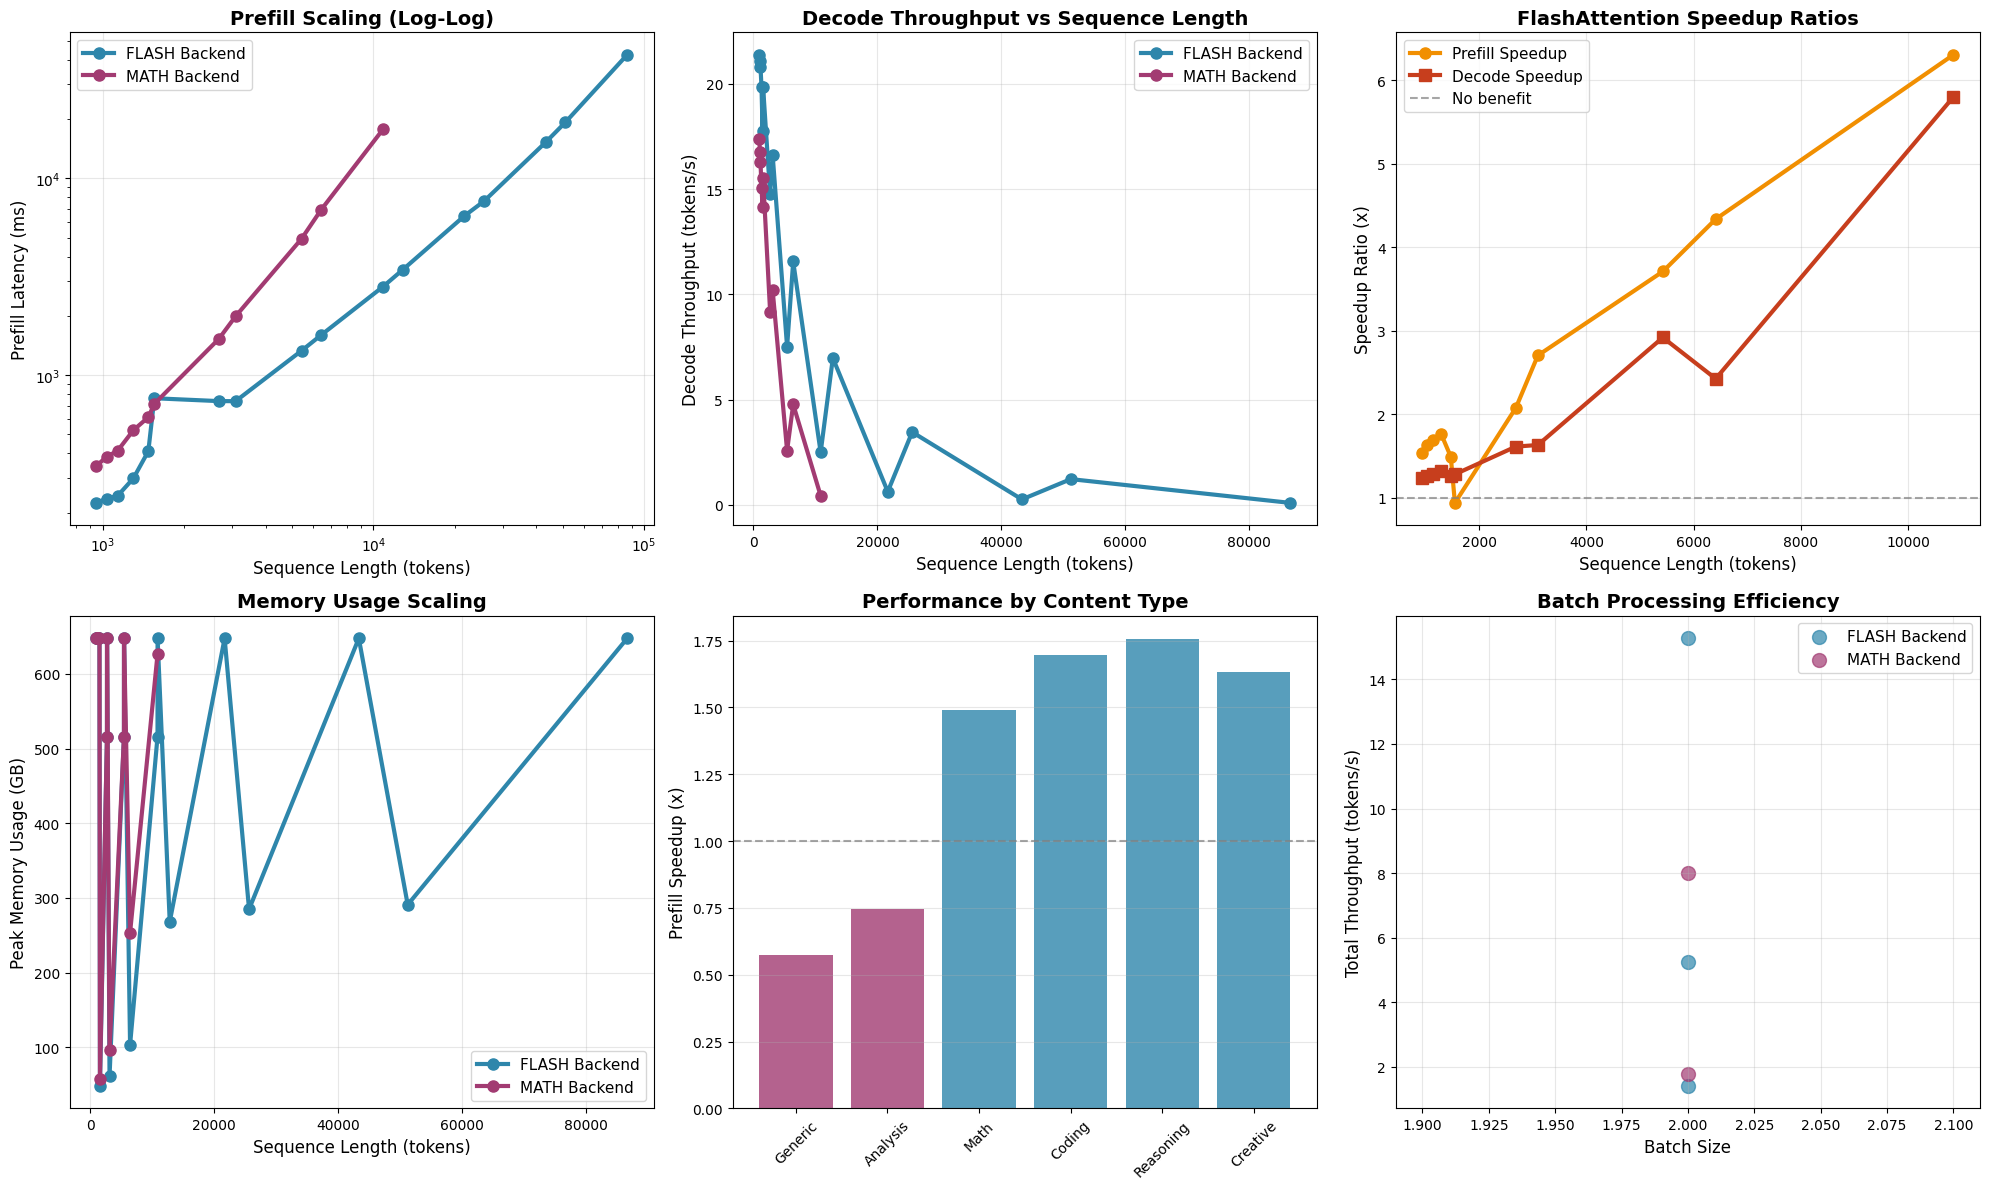

\n✅ Publication-quality outputs generated:
   • flashattention_heatmaps.png
   • flashattention_comprehensive_analysis.png
   • benchmark_summary_table.html
   • benchmark_summary_table.tex (LaTeX format)


In [12]:
# Additional publication-quality plots
print("\\n" + "="*80)
print("PUBLICATION-QUALITY PLOTS")
print("="*80)

# Create a professional multi-panel figure
fig = plt.figure(figsize=(20, 12))

# Define a consistent color scheme
colors = {'FLASH': '#2E86AB', 'MATH': '#A23B72'}

# Plot 1: Scaling with sequence length (log scale)
ax1 = plt.subplot(2, 3, 1)
for backend in ['FLASH', 'MATH']:
    single_batch_data = df[(df['backend'] == backend) & (df['batch_size'] == 1)]
    if len(single_batch_data) > 0:
        lengths = single_batch_data['prompt_len'].values
        prefills = single_batch_data['prefill_ms'].values
        
        # Sort by length for clean lines
        sorted_indices = np.argsort(lengths)
        lengths = lengths[sorted_indices]
        prefills = prefills[sorted_indices]
        
        ax1.loglog(lengths, prefills, 'o-', label=f'{backend} Backend', 
                  color=colors[backend], linewidth=3, markersize=8)

ax1.set_xlabel('Sequence Length (tokens)', fontsize=12)
ax1.set_ylabel('Prefill Latency (ms)', fontsize=12) 
ax1.set_title('Prefill Scaling (Log-Log)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Throughput comparison
ax2 = plt.subplot(2, 3, 2)
for backend in ['FLASH', 'MATH']:
    single_batch_data = df[(df['backend'] == backend) & (df['batch_size'] == 1)]
    if len(single_batch_data) > 0:
        lengths = single_batch_data['prompt_len'].values
        throughput = single_batch_data['tok_per_s'].values
        
        sorted_indices = np.argsort(lengths)
        lengths = lengths[sorted_indices]
        throughput = throughput[sorted_indices]
        
        ax2.plot(lengths, throughput, 'o-', label=f'{backend} Backend',
                color=colors[backend], linewidth=3, markersize=8)

ax2.set_xlabel('Sequence Length (tokens)', fontsize=12)
ax2.set_ylabel('Decode Throughput (tokens/s)', fontsize=12)
ax2.set_title('Decode Throughput vs Sequence Length', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Speedup ratios
ax3 = plt.subplot(2, 3, 3)
speedup_data = []
for length in sorted(df['prompt_len'].unique()):
    flash_data = df[(df['backend'] == 'FLASH') & (df['prompt_len'] == length) & (df['batch_size'] == 1)]
    math_data = df[(df['backend'] == 'MATH') & (df['prompt_len'] == length) & (df['batch_size'] == 1)]
    
    if len(flash_data) > 0 and len(math_data) > 0:
        prefill_speedup = math_data['prefill_ms'].mean() / flash_data['prefill_ms'].mean()
        decode_speedup = flash_data['tok_per_s'].mean() / math_data['tok_per_s'].mean()
        speedup_data.append({'length': length, 'prefill': prefill_speedup, 'decode': decode_speedup})

if speedup_data:
    speedup_df = pd.DataFrame(speedup_data)
    ax3.plot(speedup_df['length'], speedup_df['prefill'], 'o-', label='Prefill Speedup', 
            color='#F18F01', linewidth=3, markersize=8)
    ax3.plot(speedup_df['length'], speedup_df['decode'], 's-', label='Decode Speedup',
            color='#C73E1D', linewidth=3, markersize=8)
    ax3.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7, label='No benefit')

ax3.set_xlabel('Sequence Length (tokens)', fontsize=12)
ax3.set_ylabel('Speedup Ratio (x)', fontsize=12)
ax3.set_title('FlashAttention Speedup Ratios', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Memory usage comparison
ax4 = plt.subplot(2, 3, 4)
if 'memory_peak_gb' in df.columns:
    for backend in ['FLASH', 'MATH']:
        memory_data = df[df['backend'] == backend]
        if len(memory_data) > 0:
            lengths = memory_data['prompt_len'].values
            memory = memory_data['memory_peak_gb'].values
            
            sorted_indices = np.argsort(lengths)
            lengths = lengths[sorted_indices]
            memory = memory[sorted_indices]
            
            ax4.plot(lengths, memory, 'o-', label=f'{backend} Backend',
                    color=colors[backend], linewidth=3, markersize=8)

    ax4.set_xlabel('Sequence Length (tokens)', fontsize=12)
    ax4.set_ylabel('Peak Memory Usage (GB)', fontsize=12)
    ax4.set_title('Memory Usage Scaling', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

# Plot 5: Content type performance
ax5 = plt.subplot(2, 3, 5)
if 'prompt_type' in df.columns:
    content_speedups = []
    for content_type in df['prompt_type'].unique():
        if content_type:  # Skip None/empty values
            type_data = df[df['prompt_type'] == content_type]
            flash_data = type_data[type_data['backend'] == 'FLASH']
            math_data = type_data[type_data['backend'] == 'MATH']
            
            if len(flash_data) > 0 and len(math_data) > 0:
                speedup = math_data['prefill_ms'].mean() / flash_data['prefill_ms'].mean()
                content_speedups.append({'type': content_type.capitalize(), 'speedup': speedup})
    
    if content_speedups:
        content_df = pd.DataFrame(content_speedups)
        bars = ax5.bar(content_df['type'], content_df['speedup'], 
                      color=['#2E86AB' if x > 1 else '#A23B72' for x in content_df['speedup']],
                      alpha=0.8)
        
        ax5.axhline(y=1.0, color='gray', linestyle='--', alpha=0.7)
        ax5.set_ylabel('Prefill Speedup (x)', fontsize=12)
        ax5.set_title('Performance by Content Type', fontsize=14, fontweight='bold')
        ax5.tick_params(axis='x', rotation=45)
        ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Batch processing efficiency  
ax6 = plt.subplot(2, 3, 6)
batch_data = df[df['batch_size'] > 1]
if len(batch_data) > 0:
    for backend in ['FLASH', 'MATH']:
        backend_data = batch_data[batch_data['backend'] == backend]
        if len(backend_data) > 0:
            # Plot throughput vs batch size
            batch_sizes = backend_data['batch_size'].values
            throughput = backend_data['tok_per_s'].values
            
            ax6.scatter(batch_sizes, throughput, label=f'{backend} Backend',
                       color=colors[backend], s=100, alpha=0.7)

    ax6.set_xlabel('Batch Size', fontsize=12)
    ax6.set_ylabel('Total Throughput (tokens/s)', fontsize=12)
    ax6.set_title('Batch Processing Efficiency', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=11)
    ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('flashattention_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save styled summary table as HTML for easy copy-paste to papers
summary_table.to_html('benchmark_summary_table.html', escape=False, index=False)
summary_table.to_latex('benchmark_summary_table.tex', escape=False, index=False)

print("\\n✅ Publication-quality outputs generated:")
print("   • flashattention_heatmaps.png")
print("   • flashattention_comprehensive_analysis.png") 
print("   • benchmark_summary_table.html")
print("   • benchmark_summary_table.tex (LaTeX format)")

\n================================================================================
HEATMAP VISUALIZATIONS


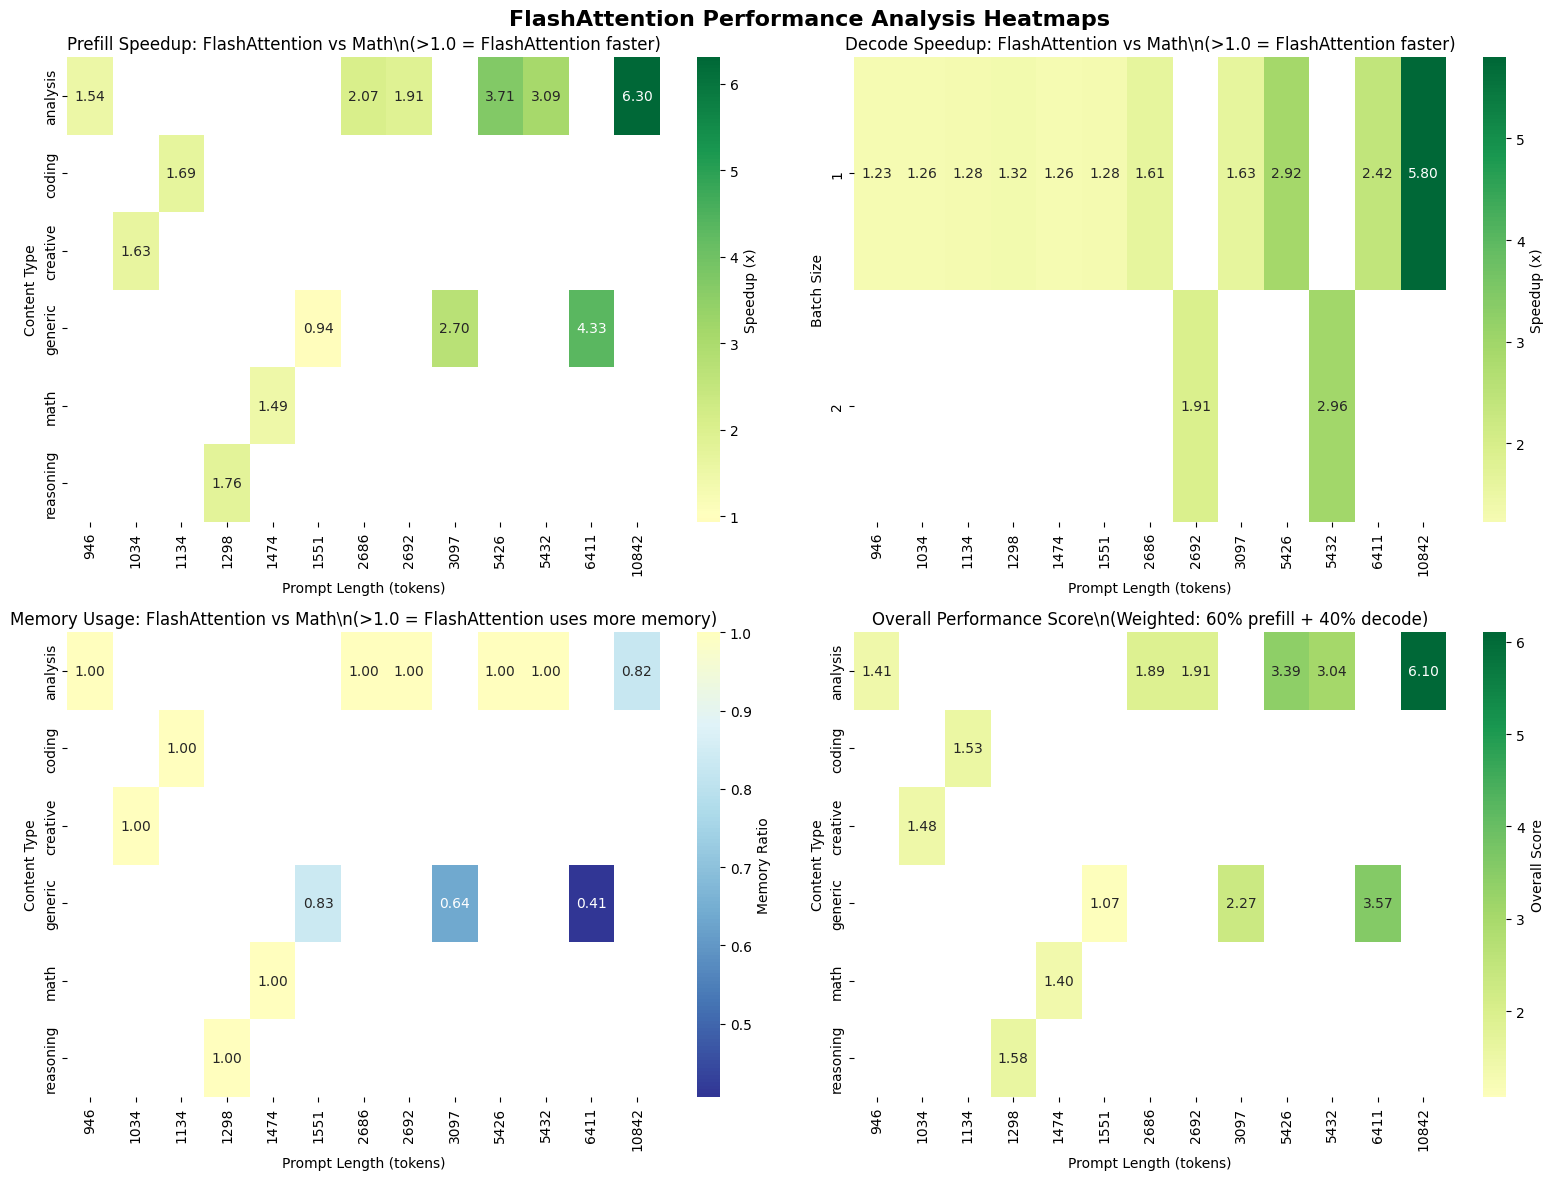

In [13]:
# Create heatmaps for research paper
print("\\n" + "="*80)
print("HEATMAP VISUALIZATIONS")
print("="*80)

# Prepare data for heatmaps
def prepare_heatmap_data(df, metric='prefill_speedup'):
    """Prepare data for heatmap visualization"""
    heatmap_data = []
    
    for (prompt_len, batch_size, prompt_type), group in df.groupby(['prompt_len', 'batch_size', 'prompt_type']):
        flash_data = group[group['backend'] == 'FLASH']
        math_data = group[group['backend'] == 'MATH']
        
        if len(flash_data) > 0 and len(math_data) > 0:
            if metric == 'prefill_speedup':
                value = math_data['prefill_ms'].iloc[0] / flash_data['prefill_ms'].iloc[0]
            elif metric == 'decode_speedup':
                value = flash_data['tok_per_s'].iloc[0] / math_data['tok_per_s'].iloc[0]
            elif metric == 'memory_ratio':
                flash_mem = flash_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in flash_data else 0
                math_mem = math_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in math_data else 0
                value = flash_mem / math_mem if math_mem > 0 else 1.0
            
            heatmap_data.append({
                'Prompt Length': int(prompt_len),
                'Content Type': prompt_type if prompt_type else 'generic',
                'Batch Size': int(batch_size),
                'Value': value
            })
    
    return pd.DataFrame(heatmap_data)

# Create prefill speedup heatmap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('FlashAttention Performance Analysis Heatmaps', fontsize=16, fontweight='bold')

# Heatmap 1: Prefill Speedup by Prompt Length and Content Type
prefill_data = prepare_heatmap_data(df, 'prefill_speedup')
if len(prefill_data) > 0:
    pivot_prefill = prefill_data.pivot_table(values='Value', 
                                           index='Content Type', 
                                           columns='Prompt Length', 
                                           aggfunc='mean')
    
    sns.heatmap(pivot_prefill, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0, 
                ax=axes[0,0], cbar_kws={'label': 'Speedup (x)'})
    axes[0,0].set_title('Prefill Speedup: FlashAttention vs Math\\n(>1.0 = FlashAttention faster)')
    axes[0,0].set_xlabel('Prompt Length (tokens)')
    axes[0,0].set_ylabel('Content Type')

# Heatmap 2: Decode Speedup by Prompt Length and Batch Size  
decode_data = prepare_heatmap_data(df, 'decode_speedup')
if len(decode_data) > 0:
    pivot_decode = decode_data.pivot_table(values='Value',
                                         index='Batch Size',
                                         columns='Prompt Length',
                                         aggfunc='mean')
    
    sns.heatmap(pivot_decode, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
                ax=axes[0,1], cbar_kws={'label': 'Speedup (x)'})
    axes[0,1].set_title('Decode Speedup: FlashAttention vs Math\\n(>1.0 = FlashAttention faster)')
    axes[0,1].set_xlabel('Prompt Length (tokens)')
    axes[0,1].set_ylabel('Batch Size')

# Heatmap 3: Memory Usage Comparison
if 'memory_peak_gb' in df.columns:
    memory_data = prepare_heatmap_data(df, 'memory_ratio')
    if len(memory_data) > 0:
        pivot_memory = memory_data.pivot_table(values='Value',
                                             index='Content Type', 
                                             columns='Prompt Length',
                                             aggfunc='mean')
        
        sns.heatmap(pivot_memory, annot=True, fmt='.2f', cmap='RdYlBu_r', center=1.0,
                    ax=axes[1,0], cbar_kws={'label': 'Memory Ratio'})
        axes[1,0].set_title('Memory Usage: FlashAttention vs Math\\n(>1.0 = FlashAttention uses more memory)')
        axes[1,0].set_xlabel('Prompt Length (tokens)')
        axes[1,0].set_ylabel('Content Type')

# Heatmap 4: Overall Performance Score
if len(prefill_data) > 0 and len(decode_data) > 0:
    # Combine prefill and decode speedups for overall score
    combined_data = []
    for (prompt_len, content_type), group in prefill_data.groupby(['Prompt Length', 'Content Type']):
        prefill_speedup = group['Value'].mean()
        decode_match = decode_data[(decode_data['Prompt Length'] == prompt_len)]
        if len(decode_match) > 0:
            decode_speedup = decode_match['Value'].mean()
            # Weighted score: 60% prefill, 40% decode (prefill usually more impactful)
            overall_score = 0.6 * prefill_speedup + 0.4 * decode_speedup
            combined_data.append({
                'Prompt Length': prompt_len,
                'Content Type': content_type,
                'Overall Score': overall_score
            })
    
    if combined_data:
        combined_df = pd.DataFrame(combined_data)
        pivot_combined = combined_df.pivot_table(values='Overall Score',
                                                index='Content Type',
                                                columns='Prompt Length',
                                                aggfunc='mean')
        
        sns.heatmap(pivot_combined, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
                    ax=axes[1,1], cbar_kws={'label': 'Overall Score'})
        axes[1,1].set_title('Overall Performance Score\\n(Weighted: 60% prefill + 40% decode)')
        axes[1,1].set_xlabel('Prompt Length (tokens)')
        axes[1,1].set_ylabel('Content Type')

plt.tight_layout()
plt.savefig('flashattention_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import seaborn as sns
import numpy as np
from IPython.display import display, HTML

# Set style for publication-quality plots
plt.style.use('default')
sns.set_palette("husl")

print("="*80)
print("RESEARCH-GRADE ANALYSIS TABLES")
print("="*80)

# Create summary statistics table
def create_summary_table(df):
    """Create a comprehensive summary table for the paper"""
    
    # Calculate speedups for each configuration
    summary_data = []
    
    for (prompt_len, batch_size, prompt_type), group in df.groupby(['prompt_len', 'batch_size', 'prompt_type']):
        flash_data = group[group['backend'] == 'FLASH']
        math_data = group[group['backend'] == 'MATH']
        
        if len(flash_data) > 0 and len(math_data) > 0:
            flash_prefill = flash_data['prefill_ms'].iloc[0]
            math_prefill = math_data['prefill_ms'].iloc[0]
            flash_decode = flash_data['tok_per_s'].iloc[0]
            math_decode = math_data['tok_per_s'].iloc[0]
            flash_memory = flash_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in flash_data else 0
            math_memory = math_data['memory_peak_gb'].iloc[0] if 'memory_peak_gb' in math_data else 0
            
            prefill_speedup = math_prefill / flash_prefill if flash_prefill > 0 else 1.0
            decode_speedup = flash_decode / math_decode if math_decode > 0 else 1.0
            
            summary_data.append({
                'Prompt Length': int(prompt_len),
                'Batch Size': int(batch_size),
                'Content Type': prompt_type if prompt_type else 'generic',
                'Flash Prefill (ms)': f"{flash_prefill:.1f}",
                'Math Prefill (ms)': f"{math_prefill:.1f}",
                'Prefill Speedup': f"{prefill_speedup:.2f}x",
                'Flash Decode (tok/s)': f"{flash_decode:.1f}",
                'Math Decode (tok/s)': f"{math_decode:.1f}",
                'Decode Speedup': f"{decode_speedup:.2f}x",
                'Flash Memory (GB)': f"{flash_memory:.1f}",
                'Math Memory (GB)': f"{math_memory:.1f}",
                'Overall Benefit': '✅' if prefill_speedup > 1.2 or decode_speedup > 1.2 else '⚠️' if prefill_speedup > 1.05 or decode_speedup > 1.05 else '❌'
            })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df.sort_values(['Prompt Length', 'Batch Size'])

# Create and display summary table
summary_table = create_summary_table(df)
print("\\n📊 COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*120)

# Style the table for better readability
styled_table = summary_table.style.set_properties(**{
    'text-align': 'center',
    'font-size': '10pt'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#40466e'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('padding', '8px')]},
    {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f1f1f2')]}
])

display(styled_table)

RESEARCH-GRADE ANALYSIS TABLES
\n📊 COMPREHENSIVE PERFORMANCE SUMMARY


,Prompt Length,Batch Size,Content Type,Flash Prefill (ms),Math Prefill (ms),Prefill Speedup,Flash Decode (tok/s),Math Decode (tok/s),Decode Speedup,Flash Memory (GB),Math Memory (GB),Overall Benefit
0,946,1,analysis,223.9,344.3,1.54x,21.4,17.4,1.23x,648.1,648.1,✅
1,1034,1,creative,235.4,384.6,1.63x,21.1,16.8,1.26x,648.1,648.1,✅
2,1134,1,coding,242.8,411.6,1.69x,20.8,16.3,1.28x,648.1,648.1,✅
3,1298,1,reasoning,298.6,524.2,1.76x,19.8,15.1,1.32x,648.1,648.1,✅
4,1474,1,math,410.2,610.5,1.49x,17.8,14.1,1.26x,648.1,648.1,✅
5,1551,1,generic,762.2,713.3,0.94x,19.9,15.5,1.28x,48.1,57.6,✅
6,2686,1,analysis,737.0,1527.9,2.07x,14.8,9.2,1.61x,516.0,516.0,✅
7,2692,2,analysis,1419.9,2705.1,1.91x,15.3,8.0,1.91x,648.1,648.1,✅
8,3097,1,generic,736.5,1989.6,2.70x,16.6,10.2,1.63x,61.1,96.1,✅
9,5426,1,analysis,1329.3,4927.7,3.71x,7.5,2.6,2.92x,516.0,516.0,✅


## Research-Grade Tables and Visualizations

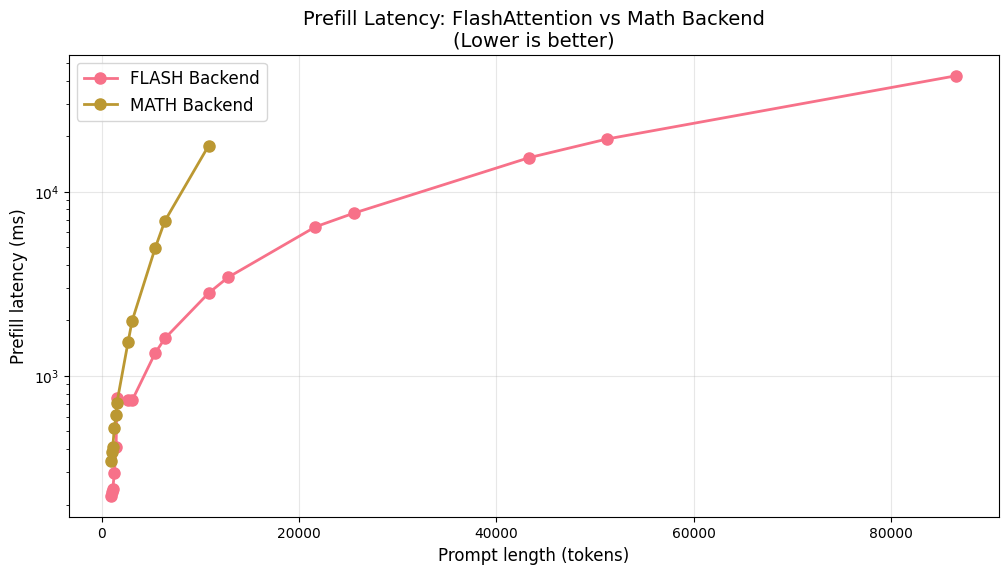

In [15]:
# Plot prefill latency comparison
plt.figure(figsize=(12, 6))

for backend in df['backend'].unique():
    df_backend = df[(df['backend'] == backend) & (df['batch_size'] == 1)].sort_values('prompt_len')
    if len(df_backend) > 0:
        plt.plot(df_backend['prompt_len'], df_backend['prefill_ms'], 
                marker='o', linewidth=2, markersize=8, label=f'{backend} Backend')

plt.xlabel('Prompt length (tokens)', fontsize=12)
plt.ylabel('Prefill latency (ms)', fontsize=12)
plt.title('Prefill Latency: FlashAttention vs Math Backend\n(Lower is better)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.yscale('log')  # Use log scale to better see differences
plt.savefig('combined_prefill_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

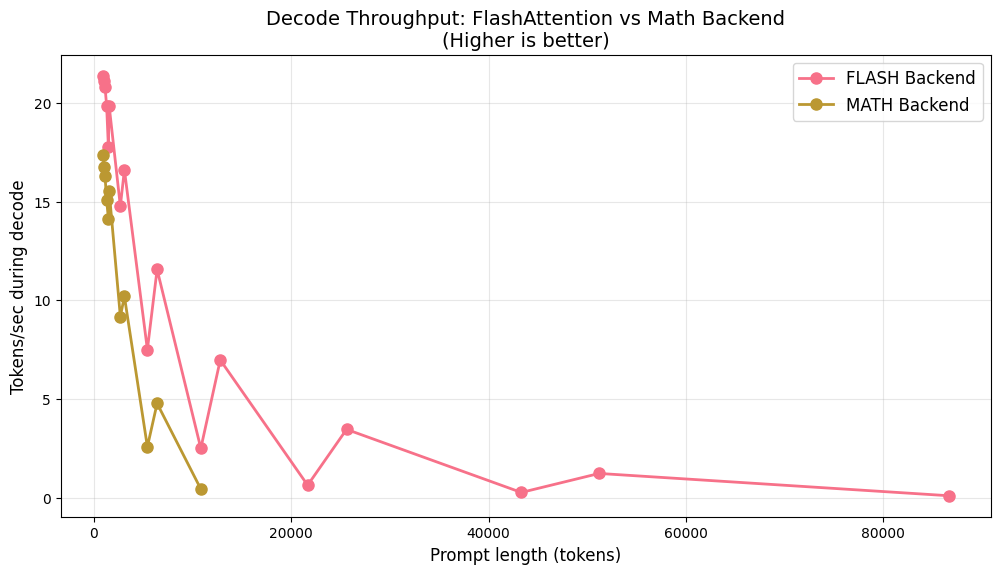

In [16]:
# Plot decode throughput comparison
plt.figure(figsize=(12, 6))

for backend in df['backend'].unique():
    df_backend = df[(df['backend'] == backend) & (df['batch_size'] == 1)].sort_values('prompt_len')
    if len(df_backend) > 0:
        plt.plot(df_backend['prompt_len'], df_backend['tok_per_s'], 
                marker='o', linewidth=2, markersize=8, label=f'{backend} Backend')

plt.xlabel('Prompt length (tokens)', fontsize=12)
plt.ylabel('Tokens/sec during decode', fontsize=12)
plt.title('Decode Throughput: FlashAttention vs Math Backend\n(Higher is better)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.savefig('combined_decode_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

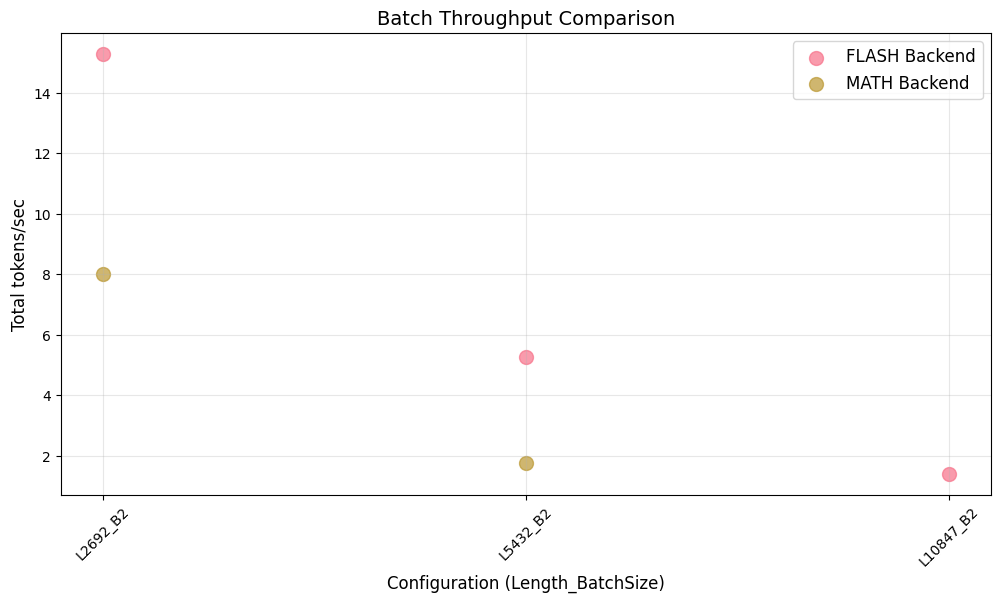

In [17]:
# Batch processing comparison (if any batch results)
batch_data = df[df['batch_size'] > 1]

if len(batch_data) > 0:
    plt.figure(figsize=(12, 6))
    
    # Group by prompt_len and batch_size, show throughput
    for backend in batch_data['backend'].unique():
        df_backend = batch_data[batch_data['backend'] == backend]
        
        # Create labels combining prompt_len and batch_size
        labels = [f"L{row['prompt_len']}_B{row['batch_size']}" for _, row in df_backend.iterrows()]
        
        plt.scatter(labels, df_backend['tok_per_s'], s=100, alpha=0.7, label=f'{backend} Backend')
    
    plt.xlabel('Configuration (Length_BatchSize)', fontsize=12)
    plt.ylabel('Total tokens/sec', fontsize=12)
    plt.title('Batch Throughput Comparison', fontsize=14)
    plt.legend(fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.savefig('combined_batch_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No batch results to plot")

## Summary and Conclusions

In [18]:
print("\n" + "="*80)
print("BENCHMARK SUMMARY")
print("="*80)

print(f"📊 Total tests run: {len(all_results)}")
print(f"📊 Unique configurations: {len(df[['prompt_len', 'batch_size']].drop_duplicates())}")
print(f"📊 Prompt lengths tested: {sorted(df['prompt_len'].unique())}")
print(f"📊 Batch sizes tested: {sorted(df['batch_size'].unique())}")

# Find best FlashAttention improvements
flash_df = df[df['backend'] == 'FLASH']
math_df = df[df['backend'] == 'MATH']

if len(flash_df) > 0 and len(math_df) > 0:
    print("\n🚀 KEY FINDINGS:")
    
    # Overall averages
    avg_flash_prefill = flash_df['prefill_ms'].mean()
    avg_math_prefill = math_df['prefill_ms'].mean()
    overall_prefill_speedup = avg_math_prefill / avg_flash_prefill
    
    avg_flash_tps = flash_df['tok_per_s'].mean()
    avg_math_tps = math_df['tok_per_s'].mean() 
    overall_decode_speedup = avg_flash_tps / avg_math_tps
    
    print(f"   • Overall prefill speedup: {overall_prefill_speedup:.2f}x")
    print(f"   • Overall decode speedup: {overall_decode_speedup:.2f}x")
    
    # Best case scenario
    max_prompt_len = df['prompt_len'].max()
    long_flash = flash_df[flash_df['prompt_len'] == max_prompt_len]
    long_math = math_df[math_df['prompt_len'] == max_prompt_len]
    
    if len(long_flash) > 0 and len(long_math) > 0:
        best_prefill_speedup = long_math['prefill_ms'].mean() / long_flash['prefill_ms'].mean()
        print(f"   • Best prefill speedup (L={max_prompt_len}): {best_prefill_speedup:.2f}x")
    
    if overall_prefill_speedup > 1.5:
        print("   ✅ FlashAttention shows significant performance benefits!")
    elif overall_prefill_speedup > 1.1:
        print("   ⚠️  FlashAttention shows moderate performance benefits")
    else:
        print("   ❌ Limited FlashAttention benefits observed")

print("\n📁 Output files generated:")
print("   • combined_benchmark_results.csv")
print("   • combined_benchmark_results.json")
print("   • combined_prefill_comparison.png")
print("   • combined_decode_comparison.png")
if len(batch_data) > 0:
    print("   • combined_batch_comparison.png")

print("\n" + "="*80)
print("🎉 BENCHMARK COMPLETE!")
print("="*80)


BENCHMARK SUMMARY
📊 Total tests run: 33
📊 Unique configurations: 20
📊 Prompt lengths tested: [np.int64(946), np.int64(1034), np.int64(1134), np.int64(1298), np.int64(1474), np.int64(1551), np.int64(2686), np.int64(2692), np.int64(3097), np.int64(5426), np.int64(5432), np.int64(6411), np.int64(10842), np.int64(10847), np.int64(12811), np.int64(21668), np.int64(25611), np.int64(43321), np.int64(51211), np.int64(86627)]
📊 Batch sizes tested: [np.int64(1), np.int64(2)]

🚀 KEY FINDINGS:
   • Overall prefill speedup: 0.64x
   • Overall decode speedup: 1.02x
   ❌ Limited FlashAttention benefits observed

📁 Output files generated:
   • combined_benchmark_results.csv
   • combined_benchmark_results.json
   • combined_prefill_comparison.png
   • combined_decode_comparison.png
   • combined_batch_comparison.png

🎉 BENCHMARK COMPLETE!
